# Predcition of Hospital Admission Related to Lower Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to lower respiratory tract infection (lrti).

In [77]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [78]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [79]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [80]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'lrti_date_'+str(i), 'lrti_ab_date_'+str(i), 'lrti_ab_type_'+str(i),
                   'incdt_lrti_date_'+str(i), 'admitted_lrti_date_'+str(i), 'sgss_gp_cov_lrti_date_'+str(i)]]
    
    #drop rows with no lrti reord
    datum = datum[datum['lrti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with lrti_i
    datum = datum[datum['sgss_gp_cov_lrti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'lrti_date_'+str(i): 'lrti_date', 'lrti_ab_date_'+str(i): 'lrti_ab_date', 
                           'lrti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_lrti_date_'+str(i): 'incdt_lrti_date', 'incdt_lrti_type_'+str(i): 'incdt_lrti_type',
                           'admitted_lrti_date_'+str(i): 'admitted_lrti_date',
                           'sgss_gp_cov_lrti_date_'+str(i): 'sgss_gp_cov_lrti_date'},
                inplace=True)
    
    return datum

In [81]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [82]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [83]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [84]:
#build cox models
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [85]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [86]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [87]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [88]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [89]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [90]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [91]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [92]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [93]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + lrti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [94]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_lrti.csv.gz')

In [95]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [96]:
#process 20 lrtis and concatenate them 
data_lrti_1 = proc_infec_data(data,1)
data_lrti_2 = proc_infec_data(data,2)
data_lrti_3 = proc_infec_data(data,3)
data_lrti_4 = proc_infec_data(data,4)
data_lrti_5 = proc_infec_data(data,5)
data_lrti_6 = proc_infec_data(data,6)
data_lrti_7 = proc_infec_data(data,7)
data_lrti_8 = proc_infec_data(data,8)
data_lrti_9 = proc_infec_data(data,9)
data_lrti_10 = proc_infec_data(data,10)
data_lrti_11 = proc_infec_data(data,11)
data_lrti_12 = proc_infec_data(data,12)
data_lrti_13 = proc_infec_data(data,13)
data_lrti_14 = proc_infec_data(data,14)
data_lrti_15 = proc_infec_data(data,15)
data_lrti_16 = proc_infec_data(data,16)
data_lrti_17 = proc_infec_data(data,17)
data_lrti_18 = proc_infec_data(data,18)
data_lrti_19 = proc_infec_data(data,19)
data_lrti_20 = proc_infec_data(data,20)

data_lrti = pd.concat([data_lrti_1, data_lrti_2, data_lrti_3, data_lrti_4, data_lrti_5, data_lrti_6, data_lrti_7, data_lrti_8, data_lrti_9, data_lrti_10, data_lrti_11, data_lrti_12, data_lrti_13, data_lrti_14, data_lrti_15, data_lrti_16, data_lrti_17, data_lrti_18, data_lrti_19, data_lrti_20])
data_lrti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [97]:
##add variable season
#convert data types
data_lrti['lrti_date'] = data_lrti['lrti_date'].astype('datetime64[ns]')
data_lrti['admitted_lrti_date'] = data_lrti['admitted_lrti_date'].astype('datetime64[ns]')
data_lrti.died_date = data_lrti.died_date.astype('datetime64[ns]')
data_lrti.deregistered_date = data_lrti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_lrti['date'] = data_lrti['lrti_date'] #gp_cons_lrti
data_lrti['date'] = data_lrti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_lrti with today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != last_1_month_date_y_m]
data_lrti = data_lrti[data_lrti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of lrti records
data_lrti['season'] = np.nan
data_lrti['date_month'] = pd.DatetimeIndex(data_lrti['date']).month

conditions = [
    (data_lrti['date_month'] >= 3) & (data_lrti['date_month'] <= 5),
    (data_lrti['date_month'] >= 6) & (data_lrti['date_month'] <= 8),
    (data_lrti['date_month'] >= 9) & (data_lrti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_lrti['season'] = np.select(conditions, choices, default='winter')

In [98]:
#add variable time period
data_lrti.loc[(data_lrti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_lrti.loc[((data_lrti['date'] >= '2020-01') & (data_lrti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_lrti.loc[(data_lrti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [99]:
#scenario 1
#not hosped (nothing happened)
data_lrti.loc[data_lrti['admitted_lrti_date'].isnull(), 'event_lrti_admitted'] = 0

In [100]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_lrti['delta_lrti_admitted'] = (data_lrti['admitted_lrti_date'] - data_lrti['lrti_date']).dt.days #gp_cons_lrti
data_lrti.loc[((data_lrti['delta_lrti_admitted'] >= 0) & (data_lrti['delta_lrti_admitted'] <= 30)), 'event_lrti_admitted'] = 1

#scenario 2
#drop whoever was admitted before lrti consultation, i.e. negative value for delta_lrti_admitted
data_lrti = data_lrti[~(data_lrti['delta_lrti_admitted'] < 0)]

In [101]:
#scenario 3
#censor died patients
data_lrti['delta_admitted_died'] = (data_lrti['died_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_lrti.loc[((data_lrti['delta_admitted_died'] >= 0) & (data_lrti['delta_admitted_died'] <= 30)), 'event_lrti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_lrti['delta_admitted_deregistered'] = (data_lrti['deregistered_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_lrti.loc[((data_lrti['delta_admitted_deregistered'] > 0) & (data_lrti['delta_admitted_deregistered'] <= 30)), 'event_lrti_admitted'] = 0

#agg scenario 3s
data_lrti['delta_admitted_died_deregistered'] = data_lrti['delta_admitted_deregistered'].combine_first(data_lrti['delta_admitted_died'])
data_lrti.loc[data_lrti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [102]:
#scenario 1
#any other patients (nothing happened)
data_lrti['event_lrti_admitted'] = data_lrti['event_lrti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_lrti['duration_lrti_admitted'] = data_lrti['delta_lrti_admitted'].combine_first(data_lrti['delta_admitted_died_deregistered'])
data_lrti['duration_lrti_admitted'] = data_lrti['duration_lrti_admitted'].replace(np.NaN, 30)
data_lrti.loc[(data_lrti['duration_lrti_admitted'] > 30), 'duration_lrti_admitted'] = 30

#give value 1 to event_lrti_admitted if duration_lrti_admitted is greater or equal to 0 and less than 30
data_lrti.loc[((data_lrti['duration_lrti_admitted'] >= 0) & (data_lrti['duration_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

#drop any rows with value 0 in duration column
data_lrti = data_lrti[~(data_lrti['duration_lrti_admitted'] == 0)]

In [103]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_lrti.loc[((data_lrti['delta_lrti_admitted'] > 0) & (data_lrti['delta_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [104]:
#prep before plot
data_lrti['age'][data_lrti['age'] < 0] = np.nan
data_lrti = data_lrti[data_lrti['age_cat'] != '0-4']
data_lrti = data_lrti[data_lrti['age_cat'] != '5-14']
#drop anybody with age less than 18
data_lrti = data_lrti[~(data_lrti['age'] < 18)]  
#assign 0 (missingness) to all bmi values less than 10
data_lrti['bmi'][data_lrti['bmi'] < 10] = 0
#replace 0s with nans
data_lrti['bmi'] = data_lrti['bmi'].replace({0:np.nan})
#remove cases with negative antibacterial_brit
data_lrti['antibacterial_brit'][data_lrti['antibacterial_brit'] < 0] = np.nan

In [105]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"smoking_status": dict_smoking})

In [106]:
#drop rows with missing region
if ('region' in data_lrti.columns) and (data_lrti['region'].isnull().sum() > 0):
   data_lrti = data_lrti[data_lrti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_lrti.columns) and (data_lrti['antibacterial_brit'].isnull().sum() > 0):
    data_lrti['antibacterial_brit'] = data_lrti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_lrti.columns) and (data_lrti['ethnicity'].isnull().sum() > 0):
    data_lrti['ethnicity'] = data_lrti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_lrti.columns) and (data_lrti['smoking_status'].isnull().sum() > 0):
    data_lrti['smoking_status'] = data_lrti['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_lrti.columns) and (data_lrti['imd'].isnull().sum() > 0):
    data_lrti['imd'] = data_lrti['imd'].fillna(0)

In [107]:
#missing values of bmi assign 5 and 0; categorise bmi
data_lrti['bmi_cat'] = 5

for idx, x in enumerate(data_lrti['bmi_cat']):
    if data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 30:
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 25) and (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 30):
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 18.5) and (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 25):
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 18.5:
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_lrti.columns) and (data_lrti['bmi_cat'].isnull().sum() > 0):
    data_lrti['bmi_cat'] = data_lrti['bmi_cat'].fillna(0)

In [108]:
##add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_lrti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_lrti['ab_type_cat'] = np.where(data_lrti['ab_type'].isin(ab_series[mask].index),'other',data_lrti['ab_type'])
#assign no to non ab users
data_lrti.loc[data_lrti['lrti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_lrti['ab_type_cat'] = data_lrti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [109]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"ethnicity": dict_ethnicity})
data_lrti = data_lrti.replace({"smoking_status": dict_smoking})
data_lrti = data_lrti.replace({"imd": dict_imd})
data_lrti = data_lrti.replace({"bmi_cat": dict_bmi})
data_lrti = data_lrti.replace({"flu_vaccine": dict_flu})
data_lrti = data_lrti.replace({"region": dict_region})
data_lrti = data_lrti.replace({"age_cat": dict_age})
data_lrti = data_lrti.replace({"ab_type_cat": dict_ab_type})
data_lrti['ab_type_cat'].value_counts()

no             159298
other           16113
Amoxicillin      1069
Doxycycline       348
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [110]:
#categorise CCI
data_lrti['CCI_cat'] = pd.cut(data_lrti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_lrti['antibacterial_brit'].clip(0, data_lrti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

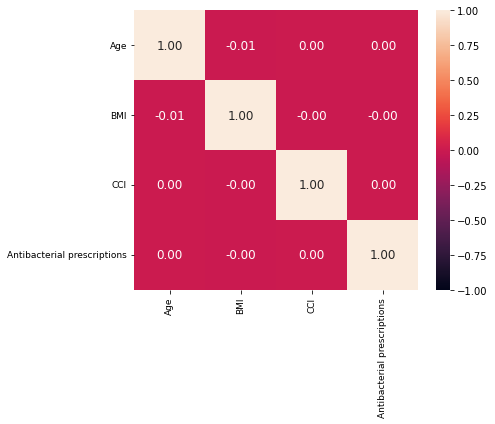

In [111]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(data_lrti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/corr_lrti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [112]:
data_lrti = data_lrti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'lrti_ab_date', 'ab_type_cat', 'incdt_lrti_date', 'date', 'period',
                       'event_lrti_admitted', 'duration_lrti_admitted'
                        ]]

In [113]:
#incident and prevalent infection 
data_lrti_incdt = data_lrti[data_lrti['incdt_lrti_date'] == 0]
data_lrti_prevl = data_lrti[data_lrti['incdt_lrti_date'] == 1]
#switch variable lrti_ab_date into a binary variable
data_lrti_incdt[['lrti_ab_date']] = data_lrti_incdt[['lrti_ab_date']].where(data_lrti_incdt[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_lrti_prevl[['lrti_ab_date']] = data_lrti_prevl[['lrti_ab_date']].where(data_lrti_prevl[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_lrti_incdt_males = data_lrti_incdt[data_lrti_incdt['sex'] == 'male']
data_lrti_incdt_females = data_lrti_incdt[data_lrti_incdt['sex'] == 'female']
data_lrti_prevl_males = data_lrti_prevl[data_lrti_prevl['sex'] == 'male']
data_lrti_prevl_females = data_lrti_prevl[data_lrti_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_lrti_incdt_15_24 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '15_24']
data_lrti_incdt_25_34 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '25_34']
data_lrti_incdt_35_44 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '35_44']
data_lrti_incdt_45_54 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '45_54']
data_lrti_incdt_55_64 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '55_64']
data_lrti_incdt_65_74 = data_lrti_incdt[data_lrti_incdt['age_cat'] == '65_74']
data_lrti_incdt_75_more = data_lrti_incdt[data_lrti_incdt['age_cat'] == '75_more']
data_lrti_prevl_15_24 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '15_24']
data_lrti_prevl_25_34 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '25_34']
data_lrti_prevl_35_44 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '35_44']
data_lrti_prevl_45_54 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '45_54']
data_lrti_prevl_55_64 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '55_64']
data_lrti_prevl_65_74 = data_lrti_prevl[data_lrti_prevl['age_cat'] == '65_74']
data_lrti_prevl_75_more = data_lrti_prevl[data_lrti_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_lrti_incdt_prepandemic = data_lrti_incdt[data_lrti_incdt['date'] <= '2019-12']
data_lrti_incdt_during_pandemic = data_lrti_incdt[(data_lrti_incdt['date'] >= '2020-03') & (data_lrti_incdt['date']<= '2021-03')]
data_lrti_incdt_post_2nd_lockdown = data_lrti_incdt[data_lrti_incdt['date'] <= '2021-04']
data_lrti_prevl_prepandemic = data_lrti_prevl[data_lrti_prevl['date'] <= '2019-12']
data_lrti_prevl_during_pandemic = data_lrti_prevl[(data_lrti_prevl['date'] >= '2020-03') & (data_lrti_prevl['date']<= '2021-03')]
data_lrti_prevl_post_2nd_lockdown = data_lrti_prevl[data_lrti_prevl['date'] <= '2021-04']

##separate data into sub-datasets
#no antibiotics and incident hospital admission
data_lrti_no_abs_incdt = data_lrti[data_lrti['lrti_ab_date'].isnull()]
data_lrti_no_abs_incdt = data_lrti_no_abs_incdt[data_lrti_no_abs_incdt['incdt_lrti_date'] == 0]
#with antibiotics and incident hospital admission
data_lrti_abs_incdt = data_lrti[data_lrti['lrti_ab_date'].notnull()]
data_lrti_abs_incdt = data_lrti_abs_incdt[data_lrti_abs_incdt['incdt_lrti_date'] == 0]
#no antibiotics and prevalent hospital admission
data_lrti_no_abs_prevl = data_lrti[data_lrti['lrti_ab_date'].isnull()]
data_lrti_no_abs_prevl = data_lrti_no_abs_prevl[data_lrti_no_abs_prevl['incdt_lrti_date'] == 1]
#with antibiotics and prevalent hospital admission
data_lrti_abs_prevl = data_lrti[data_lrti['lrti_ab_date'].notnull()]
data_lrti_abs_prevl = data_lrti_abs_prevl[data_lrti_abs_prevl['incdt_lrti_date'] == 1]

In [114]:
#store data for plotting hosp admission counts and percentages
%store data_lrti
# save data
data_lrti.to_csv('../output/hospitalisation_prediction_lrti/data_lrti.csv')

Stored 'data_lrti' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident lrti with no antibiotics

<lifelines.CoxPHFitter: fitted with 107475 total observations, 106716 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 107475
number of events observed = 759
   partial log-likelihood = -8769.99
         time fit was run = 2023-01-25 16:31:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.11            -0.27             0.15                 0.77                 1.16
CCI_cat[T.medium]               -0.10       0.91       0.12            -0.33             0.13                 0.72                 1.14
CCI_cat[T.high]                 -0.04       0.96       0.14            -0.31             0.23                 0.73                 1.26
CCI_cat[T.very_high]            -0.08       0.92       0.12            -0.33             0.16                 0.72                 1.17
age_cat[T.25_34]                 0.01       1.01       0.14            -0.27             0.28                 0.77                 1.32
age_cat[T.35_44]                 0.05       1.05       0.14            -0.22             0.32                 0.80                 1.38
age_cat[T.45_54]                 0.12       1.13       0.14            -0.14             0.39                 0.87                 1.48
age_cat[T.55_64]                 0.04       1.04       0.14            -0.24             0.31                 0.79                 1.36
age_cat[T.65_74]                 0.12       1.13       0.14            -0.15             0.38                 0.86                 1.47
age_cat[T.75_more]               0.01       1.01       0.14            -0.26             0.28                 0.77                 1.33
antibacterial_brit              -0.02       0.98       0.03            -0.07             0.03                 0.93                 1.03
bmi_cat[T.obese]                -0.19       0.83       0.13            -0.44             0.06                 0.64                 1.06
bmi_cat[T.overweight]           -0.10       0.90       0.16            -0.41             0.21                 0.66                 1.23
bmi_cat[T.underweight]          -0.37       0.69       0.26            -0.87             0.14                 0.42                 1.15
bmi_cat[T.unknown]              -0.12       0.89       0.14            -0.39             0.15                 0.68                 1.16
ethnicity[T.unknown]            -0.08       0.92       0.12            -0.32             0.15                 0.73                 1.17
ethnicity[T.white]               0.04       1.04       0.10            -0.17             0.24                 0.85                 1.27
flu_vaccine[T.yes]               0.18       1.19       0.11            -0.05             0.40                 0.96                 1.49
imd[T.medium]                    0.00       1.00       0.12            -0.23             0.23                 0.80                 1.26
imd[T.unaffluent]               -0.00       1.00       0.12            -0.23             0.23                 0.79                 1.26
imd[T.unknown]                  -0.00       1.00       0.18            -0.36             0.35                 0.70                 1.42
imd[T.very_affluent]            -0.08       0.92       0.12            -0.32             0.15                 0.73                 1.16
imd[T.very_unaffluent]           0.02       1.02       0.12            -0.21             0.25                 0.81                 1.28
region[T.east_midlands]          0.23       1.26       0.17            -0.11             0.57                 0.89                 1.77
region[T.london]                 0.22       1.25       0.15      

11951


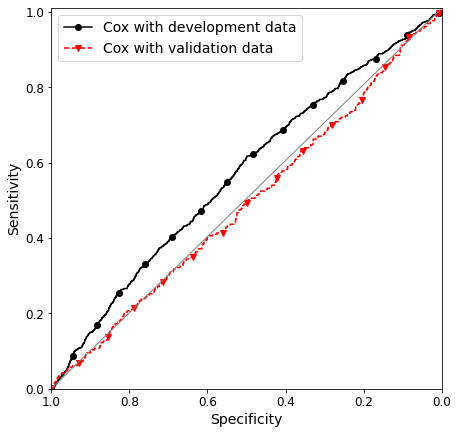

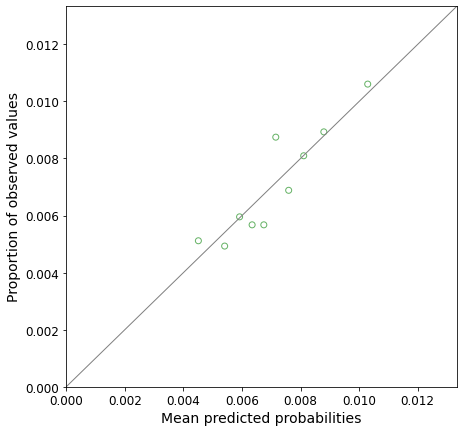

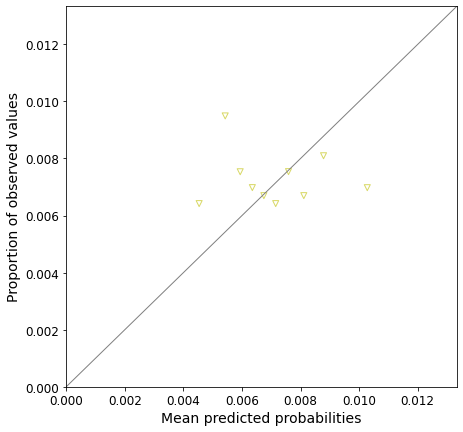

In [115]:
#data prep
data, data_lrti_no_abs_incdt_enc = cox_data_prep(data_lrti_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)

try:
    #build cox model 
    cph_lrti_no_abs_incdt, data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test = cox_model_build('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_lrti_no_abs_incdt, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_no_abs_incdt.csv', data_lrti_no_abs_incdt_enc, data_lrti_no_abs_incdt, 'sum_betas_cph_lrti_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_lrti_no_abs_incdt, 'event_lrti_admitted', data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_lrti_no_abs_incdt, data_lrti_no_abs_incdt_train, 'event_lrti_admitted', data_lrti_no_abs_incdt_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_no_abs_incdt_train.jpg', 'calibration_cph_lrti_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_no_abs_incdt, 'lrti', 'no_abs_incdt', data_lrti_no_abs_incdt_train, data_lrti_no_abs_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident lrti with antibiotics

<lifelines.CoxPHFitter: fitted with 11868 total observations, 11791 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 11868
number of events observed = 77
   partial log-likelihood = -711.95
         time fit was run = 2023-01-25 16:31:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.14       1.15       0.34            -0.54             0.81                 0.59                 2.25
CCI_cat[T.medium]                0.15       1.16       0.38            -0.59             0.89                 0.55                 2.44
CCI_cat[T.high]                 -0.09       0.92       0.48            -1.02             0.85                 0.36                 2.33
CCI_cat[T.very_high]            -0.02       0.98       0.41            -0.82             0.78                 0.44                 2.19
age_cat[T.25_34]                -0.03       0.97       0.41            -0.83             0.77                 0.43                 2.16
age_cat[T.35_44]                -0.09       0.91       0.42            -0.91             0.73                 0.40                 2.07
age_cat[T.45_54]                -0.16       0.85       0.43            -1.00             0.68                 0.37                 1.98
age_cat[T.55_64]                 0.06       1.07       0.40            -0.72             0.85                 0.49                 2.34
age_cat[T.65_74]                -0.29       0.75       0.44            -1.15             0.58                 0.32                 1.78
age_cat[T.75_more]              -0.20       0.82       0.43            -1.04             0.64                 0.35                 1.89
antibacterial_brit              -0.04       0.96       0.08            -0.20             0.12                 0.82                 1.13
bmi_cat[T.obese]                 0.75       2.12       0.60            -0.42             1.92                 0.66                 6.84
bmi_cat[T.overweight]            0.79       2.20       0.67            -0.52             2.10                 0.59                 8.14
bmi_cat[T.underweight]           0.43       1.53       0.91            -1.37             2.22                 0.26                 9.19
bmi_cat[T.unknown]               0.70       2.00       0.62            -0.52             1.91                 0.59                 6.76
ethnicity[T.unknown]             0.23       1.26       0.39            -0.53             0.98                 0.59                 2.67
ethnicity[T.white]               0.13       1.14       0.35            -0.55             0.82                 0.57                 2.26
flu_vaccine[T.yes]              -0.43       0.65       0.46            -1.33             0.48                 0.26                 1.62
imd[T.medium]                   -0.23       0.79       0.41            -1.04             0.57                 0.35                 1.77
imd[T.unaffluent]                0.02       1.02       0.39            -0.74             0.77                 0.48                 2.16
imd[T.unknown]                   0.47       1.61       0.49            -0.50             1.44                 0.61                 4.24
imd[T.very_affluent]            -0.17       0.85       0.40            -0.95             0.62                 0.39                 1.86
imd[T.very_unaffluent]           0.44       1.55       0.35            -0.25             1.13                 0.78                 3.10
region[T.east_midlands]          0.50       1.64       0.63            -0.73             1.72                 0.48                 5.61
region[T.london]                 0.38       1.46       0.58           

11955


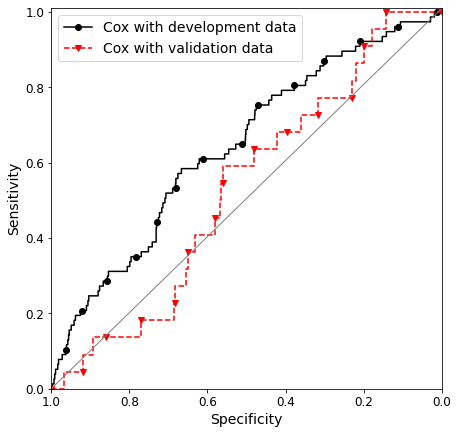

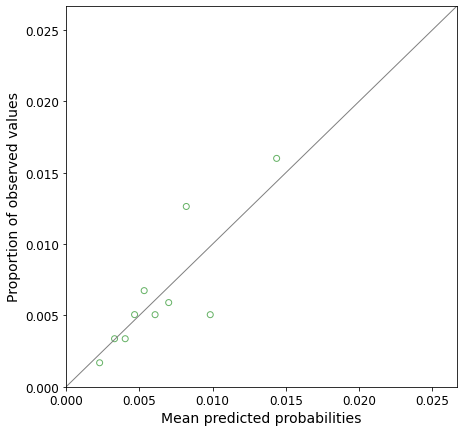

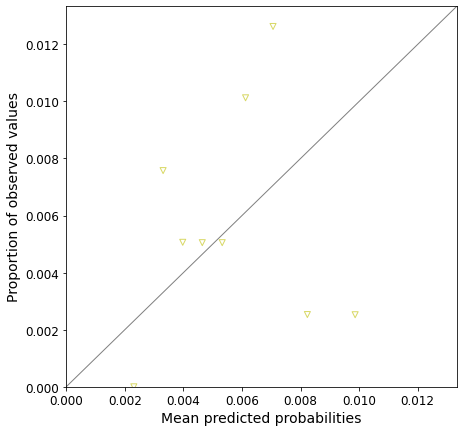

In [116]:
#data prep
data, data_lrti_abs_incdt_enc = cox_data_prep(data_lrti_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'abs_incdt', data_lrti_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'abs_incdt', data_lrti_abs_incdt)

try:
    #build cox model 
    cph_lrti_abs_incdt, data_lrti_abs_incdt_train, data_lrti_abs_incdt_test = cox_model_build('lrti', 'abs_incdt', data_lrti_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_lrti_abs_incdt, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_abs_incdt.csv', data_lrti_abs_incdt_enc, data_lrti_abs_incdt, 'sum_betas_cph_lrti_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_lrti_abs_incdt, 'event_lrti_admitted', data_lrti_abs_incdt_train, data_lrti_abs_incdt_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_lrti_abs_incdt, data_lrti_abs_incdt_train, 'event_lrti_admitted', data_lrti_abs_incdt_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_abs_incdt_train.jpg', 'calibration_cph_lrti_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_abs_incdt, 'lrti', 'abs_incdt', data_lrti_abs_incdt_train, data_lrti_abs_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent lrti with no antibiotics

<lifelines.CoxPHFitter: fitted with 11998 total observations, 11923 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 11998
number of events observed = 75
   partial log-likelihood = -685.49
         time fit was run = 2023-01-25 16:32:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.36       1.43       0.37            -0.36             1.08                 0.70                 2.94
CCI_cat[T.medium]                0.08       1.09       0.42            -0.74             0.91                 0.48                 2.48
CCI_cat[T.high]                  0.47       1.59       0.45            -0.41             1.34                 0.66                 3.84
CCI_cat[T.very_high]             0.32       1.37       0.42            -0.51             1.14                 0.60                 3.13
age_cat[T.25_34]                 0.27       1.32       0.42            -0.55             1.10                 0.58                 3.01
age_cat[T.35_44]                 0.35       1.41       0.41            -0.46             1.15                 0.63                 3.15
age_cat[T.45_54]                -0.24       0.79       0.48            -1.17             0.69                 0.31                 2.00
age_cat[T.55_64]                -0.02       0.99       0.45            -0.89             0.86                 0.41                 2.37
age_cat[T.65_74]                -0.24       0.78       0.48            -1.18             0.69                 0.31                 1.99
age_cat[T.75_more]               0.04       1.04       0.44            -0.82             0.89                 0.44                 2.44
antibacterial_brit              -0.03       0.97       0.08            -0.19             0.14                 0.83                 1.15
bmi_cat[T.obese]                 0.05       1.05       0.44            -0.82             0.91                 0.44                 2.48
bmi_cat[T.overweight]           -0.20       0.82       0.56            -1.30             0.89                 0.27                 2.44
bmi_cat[T.underweight]         -15.76       0.00    1829.14         -3600.82          3569.30                 0.00                  inf
bmi_cat[T.unknown]               0.26       1.30       0.46            -0.64             1.16                 0.53                 3.20
ethnicity[T.unknown]            -0.21       0.81       0.38            -0.96             0.54                 0.38                 1.72
ethnicity[T.white]               0.01       1.01       0.32            -0.62             0.65                 0.54                 1.92
flu_vaccine[T.yes]              -0.37       0.69       0.46            -1.28             0.54                 0.28                 1.71
imd[T.medium]                    0.01       1.01       0.44            -0.85             0.87                 0.43                 2.38
imd[T.unaffluent]                0.54       1.72       0.39            -0.23             1.32                 0.79                 3.72
imd[T.unknown]                   0.80       2.23       0.52            -0.21             1.82                 0.81                 6.16
imd[T.very_affluent]             0.41       1.50       0.40            -0.39             1.20                 0.68                 3.31
imd[T.very_unaffluent]           0.26       1.30       0.41            -0.55             1.07                 0.58                 2.93
region[T.east_midlands]         -0.72       0.49       0.71            -2.11             0.67                 0.12                 1.95
region[T.london]                 0.49       1.64       0.47           

11966


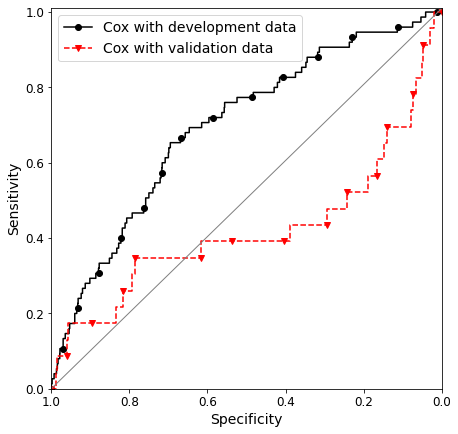

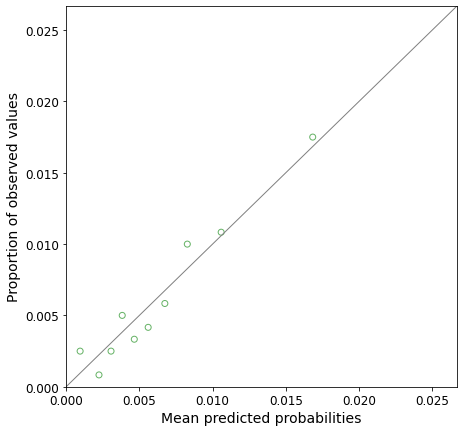

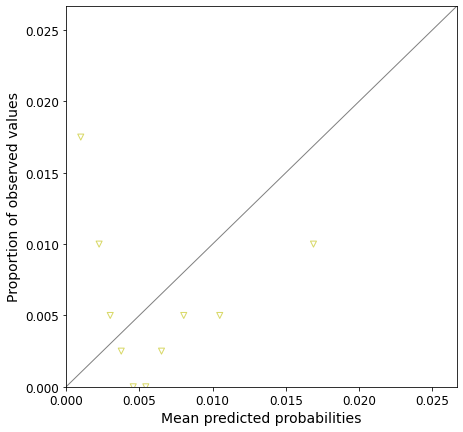

In [117]:
#data prep
data, data_lrti_no_abs_prevl_enc = cox_data_prep(data_lrti_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl)

try:
    #build cox model 
    cph_lrti_no_abs_prevl, data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test = cox_model_build('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_lrti_no_abs_prevl, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_no_abs_prevl.csv', data_lrti_no_abs_prevl_enc, data_lrti_no_abs_prevl, 'sum_betas_cph_lrti_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_lrti_no_abs_prevl, 'event_lrti_admitted', data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_lrti_no_abs_prevl, data_lrti_no_abs_prevl_train, 'event_lrti_admitted', data_lrti_no_abs_prevl_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_no_abs_prevl_train.jpg', 'calibration_cph_lrti_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_no_abs_prevl, 'lrti', 'no_abs_prevl', data_lrti_no_abs_prevl_train, data_lrti_no_abs_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent lrti with antibiotics

<lifelines.CoxPHFitter: fitted with 1278 total observations, 1266 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1278
number of events observed = 12
   partial log-likelihood = -61.31
         time fit was run = 2023-01-25 16:32:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.05       1.05       0.84            -1.59             1.69                 0.20                 5.40
CCI_cat[T.medium]               -1.55       0.21       1.27            -4.05             0.94                 0.02                 2.56
CCI_cat[T.high]                  0.67       1.96       1.06            -1.40             2.75                 0.25                15.59
CCI_cat[T.very_high]            -1.06       0.35       1.28            -3.58             1.46                 0.03                 4.29
age_cat[T.25_34]                17.65   4.62e+07    6589.36        -12897.26         12932.55                 0.00                  inf
age_cat[T.35_44]                18.98   1.75e+08    6589.36        -12895.92         12933.89                 0.00                  inf
age_cat[T.45_54]                17.27   3.18e+07    6589.36        -12897.63         12932.18                 0.00                  inf
age_cat[T.55_64]                17.21   2.97e+07    6589.36        -12897.70         12932.11                 0.00                  inf
age_cat[T.65_74]                18.43   1.01e+08    6589.36        -12896.47         12933.34                 0.00                  inf
age_cat[T.75_more]              19.39   2.62e+08    6589.36        -12895.52         12934.29                 0.00                  inf
antibacterial_brit               0.18       1.19       0.22            -0.26             0.61                 0.77                 1.85
bmi_cat[T.obese]                 1.73       5.64       1.35            -0.91             4.37                 0.40                79.05
bmi_cat[T.overweight]            1.84       6.30       1.48            -1.07             4.75                 0.34               115.19
bmi_cat[T.underweight]           2.06       7.88       1.71            -1.30             5.43                 0.27               227.05
bmi_cat[T.unknown]             -17.21       0.00    4653.92         -9138.72          9104.30                 0.00                  inf
ethnicity[T.unknown]            -0.81       0.44       1.04            -2.85             1.22                 0.06                 3.39
ethnicity[T.white]              -0.57       0.57       0.79            -2.12             0.99                 0.12                 2.69
flu_vaccine[T.yes]               1.38       3.98       0.83            -0.25             3.02                 0.78                20.44
imd[T.medium]                   -0.07       0.93       1.08            -2.18             2.04                 0.11                 7.67
imd[T.unaffluent]               -0.09       0.91       0.98            -2.01             1.83                 0.13                 6.26
imd[T.unknown]                   1.50       4.47       1.10            -0.65             3.64                 0.52                38.25
imd[T.very_affluent]           -18.36       0.00    5674.89        -11140.94         11104.21                 0.00                  inf
imd[T.very_unaffluent]          -0.23       0.80       1.04            -2.27             1.81                 0.10                 6.12
region[T.east_midlands]        -19.22       0.00    9413.42        -18469.18         18430.74                 0.00                  inf
region[T.london]               -19.30       0.00    5746.92        -11283.

12141


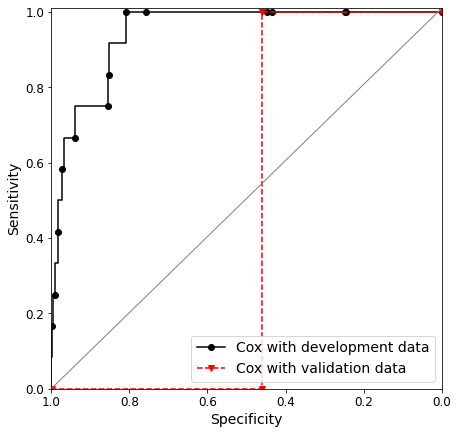

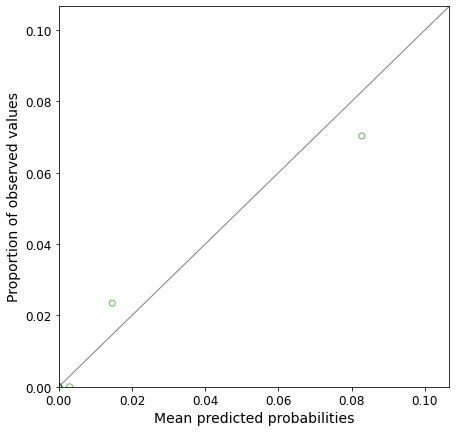

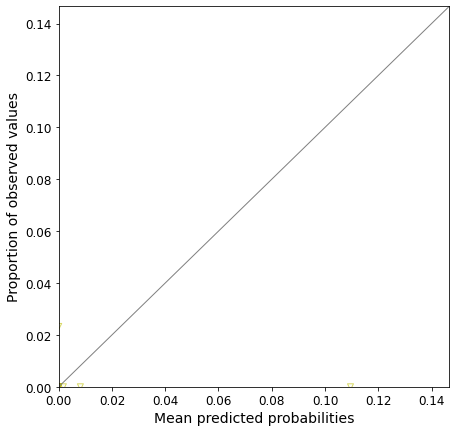

In [118]:
#data prep
data, data_lrti_abs_prevl_enc = cox_data_prep(data_lrti_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary table
make_summary_table('lrti', 'abs_prevl', data_lrti_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('lrti', 'abs_prevl', data_lrti_abs_prevl)

try:
    #build cox model 
    cph_lrti_abs_prevl, data_lrti_abs_prevl_train, data_lrti_abs_prevl_test = cox_model_build('lrti', 'abs_prevl', data_lrti_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_lrti_abs_prevl, '../output/hospitalisation_prediction_lrti/', 'betas_cph_lrti_abs_prevl.csv', data_lrti_abs_prevl_enc, data_lrti_abs_prevl, 'sum_betas_cph_lrti_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_lrti_abs_prevl, 'event_lrti_admitted', data_lrti_abs_prevl_train, data_lrti_abs_prevl_test, '../output/hospitalisation_prediction_lrti', 'roc_cph_lrti_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_lrti_abs_prevl, data_lrti_abs_prevl_train, 'event_lrti_admitted', data_lrti_abs_prevl_test, '../output/hospitalisation_prediction_lrti/', 'calibration_cph_lrti_abs_prevl_train.jpg', 'calibration_cph_lrti_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_abs_prevl, 'lrti', 'abs_prevl', data_lrti_abs_prevl_train, data_lrti_abs_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident lrti

In [119]:
#data prep
data, data_lrti_incdt_enc = cox_data_prep(data_lrti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary tables from preped data
make_summary_table('lrti', 'incdt', data_lrti_incdt_enc)
make_summary_table_hosped('lrti', 'incdt', data_lrti_incdt)

try:
    cph_lrti_incdt, data_lrti_incdt_train, data_lrti_incdt_test = cox_model_abs_build('lrti', 'incdt', data_lrti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt, 'lrti', 'incdt', data_lrti_incdt_train, data_lrti_incdt_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 119343 total observations, 118532 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 119343
number of events observed = 811
   partial log-likelihood = -9462.74
         time fit was run = 2023-01-25 16:32:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.10            -0.21             0.19                 0.81                 1.21
CCI_cat[T.medium]               -0.06       0.94       0.12            -0.29             0.16                 0.75                 1.18
CCI_cat[T.high]                 -0.10       0.91       0.14            -0.37             0.18                 0.69                 1.19
CCI_cat[T.very_high]             0.04       1.04       0.12            -0.19             0.28                 0.83                 1.32
age_cat[T.25_34]                -0.13       0.88       0.13            -0.39             0.14                 0.68                 1.15
age_cat[T.35_44]                -0.02       0.98       0.13            -0.28             0.23                 0.76                 1.26
age_cat[T.45_54]                 0.03       1.03       0.13            -0.23             0.28                 0.80                 1.32
age_cat[T.55_64]                -0.01       0.99       0.13            -0.26             0.24                 0.77                 1.28
age_cat[T.65_74]                -0.08       0.92       0.13            -0.34             0.18                 0.71                 1.20
age_cat[T.75_more]              -0.01       0.99       0.13            -0.27             0.24                 0.77                 1.27
antibacterial_brit              -0.05       0.95       0.03            -0.10             0.00                 0.91                 1.00
bmi_cat[T.obese]                -0.09       0.91       0.13            -0.35             0.16                 0.71                 1.18
bmi_cat[T.overweight]            0.01       1.01       0.16            -0.30             0.31                 0.74                 1.37
bmi_cat[T.underweight]          -0.46       0.63       0.27            -0.99             0.07                 0.37                 1.07
bmi_cat[T.unknown]               0.02       1.02       0.14            -0.25             0.28                 0.78                 1.33
ethnicity[T.unknown]             0.19       1.20       0.12            -0.04             0.42                 0.96                 1.52
ethnicity[T.white]               0.12       1.12       0.11            -0.09             0.32                 0.91                 1.38
flu_vaccine[T.yes]               0.10       1.10       0.11            -0.12             0.32                 0.88                 1.38
imd[T.medium]                   -0.11       0.89       0.11            -0.34             0.11                 0.71                 1.12
imd[T.unaffluent]               -0.07       0.93       0.11            -0.29             0.15                 0.75                 1.16
imd[T.unknown]                  -0.06       0.95       0.17            -0.40             0.29                 0.67                 1.33
imd[T.very_affluent]            -0.10       0.91       0.11            -0.32             0.12                 0.72                 1.13
imd[T.very_unaffluent]          -0.03       0.97       0.11            -0.25             0.19                 0.78                 1.20
lrti_ab_date                    -0.00       1.00       0.12            -0.24             0.23                 0.79                 1.25
region[T.east_midlands]          0.14       1.15       0.16      

12212


### 5-6- hospital admission related to prevalent lrti

In [120]:
#data prep
data, data_lrti_prevl_enc = cox_data_prep(data_lrti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

#make summary tables from preped data
make_summary_table('lrti', 'prevl', data_lrti_prevl_enc)
make_summary_table_hosped('lrti', 'prevl', data_lrti_prevl)

try:
    cph_lrti_prevl, data_lrti_prevl_train, data_lrti_prevl_test = cox_model_abs_build('lrti', 'prevl', data_lrti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl, 'lrti', 'prevl', data_lrti_prevl_train, data_lrti_prevl_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13277 total observations, 13191 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 13277
number of events observed = 86
   partial log-likelihood = -801.77
         time fit was run = 2023-01-25 16:32:14 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.52       1.68       0.36            -0.19             1.23                 0.83                 3.41
CCI_cat[T.medium]                0.23       1.26       0.41            -0.57             1.03                 0.56                 2.80
CCI_cat[T.high]                  0.66       1.93       0.43            -0.18             1.50                 0.83                 4.48
CCI_cat[T.very_high]             0.45       1.56       0.41            -0.35             1.25                 0.70                 3.48
age_cat[T.25_34]                 0.28       1.33       0.42            -0.54             1.11                 0.58                 3.04
age_cat[T.35_44]                 0.41       1.51       0.40            -0.38             1.20                 0.68                 3.34
age_cat[T.45_54]                -0.50       0.61       0.52            -1.51             0.52                 0.22                 1.68
age_cat[T.55_64]                 0.31       1.36       0.41            -0.50             1.12                 0.60                 3.07
age_cat[T.65_74]                 0.23       1.26       0.42            -0.59             1.06                 0.55                 2.88
age_cat[T.75_more]               0.34       1.40       0.42            -0.48             1.15                 0.62                 3.16
antibacterial_brit              -0.05       0.95       0.08            -0.20             0.11                 0.82                 1.11
bmi_cat[T.obese]                -0.25       0.78       0.37            -0.96             0.47                 0.38                 1.60
bmi_cat[T.overweight]           -0.28       0.76       0.46            -1.18             0.62                 0.31                 1.87
bmi_cat[T.underweight]          -0.43       0.65       0.78            -1.97             1.11                 0.14                 3.02
bmi_cat[T.unknown]              -0.31       0.73       0.40            -1.10             0.48                 0.33                 1.61
ethnicity[T.unknown]             0.00       1.00       0.33            -0.64             0.64                 0.53                 1.90
ethnicity[T.white]              -0.27       0.76       0.30            -0.86             0.31                 0.43                 1.37
flu_vaccine[T.yes]               0.25       1.29       0.34            -0.41             0.91                 0.66                 2.49
imd[T.medium]                    0.25       1.28       0.38            -0.50             0.99                 0.60                 2.70
imd[T.unaffluent]                0.40       1.49       0.37            -0.32             1.12                 0.72                 3.08
imd[T.unknown]                   0.58       1.78       0.50            -0.41             1.56                 0.67                 4.75
imd[T.very_affluent]             0.14       1.15       0.39            -0.63             0.91                 0.53                 2.48
imd[T.very_unaffluent]           0.37       1.45       0.37            -0.35             1.10                 0.70                 2.99
lrti_ab_date                     0.07       1.08       0.35            -0.62             0.76                 0.54                 2.15
region[T.east_midlands]         -0.15       0.86       0.56           

12203


### 5-7- hospital admission related to incident lrti with prescribed antibiotics categories

In [121]:
#data prep
data, data_lrti_incdt_abs_enc = cox_data_prep(data_lrti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_abs, data_lrti_incdt_abs_train, data_lrti_incdt_abs_test = cox_model_ab_type_build('lrti', 'incdt_ab_type', data_lrti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_abs, 'lrti', 'incdt_abs', data_lrti_incdt_abs_train, data_lrti_incdt_abs_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 119343 total observations, 118532 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 119343
number of events observed = 811
   partial log-likelihood = -9462.34
         time fit was run = 2023-01-25 16:32:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.10            -0.21             0.19                 0.81                 1.21
CCI_cat[T.medium]               -0.06       0.94       0.12            -0.29             0.16                 0.75                 1.18
CCI_cat[T.high]                 -0.10       0.91       0.14            -0.37             0.18                 0.69                 1.19
CCI_cat[T.very_high]             0.04       1.04       0.12            -0.19             0.28                 0.83                 1.32
ab_type_cat[T.Doxycycline]       0.60       1.83       0.91            -1.19             2.39                 0.30                10.93
ab_type_cat[T.no]                0.46       1.59       0.58            -0.67             1.60                 0.51                 4.93
ab_type_cat[T.other]             0.48       1.61       0.59            -0.68             1.63                 0.51                 5.10
age_cat[T.25_34]                -0.13       0.88       0.13            -0.39             0.14                 0.68                 1.15
age_cat[T.35_44]                -0.02       0.98       0.13            -0.28             0.23                 0.76                 1.26
age_cat[T.45_54]                 0.03       1.03       0.13            -0.23             0.28                 0.80                 1.32
age_cat[T.55_64]                -0.01       0.99       0.13            -0.26             0.24                 0.77                 1.28
age_cat[T.65_74]                -0.08       0.92       0.13            -0.34             0.18                 0.71                 1.20
age_cat[T.75_more]              -0.01       0.99       0.13            -0.27             0.24                 0.77                 1.27
antibacterial_brit              -0.05       0.95       0.03            -0.10             0.00                 0.91                 1.00
bmi_cat[T.obese]                -0.09       0.91       0.13            -0.35             0.16                 0.71                 1.18
bmi_cat[T.overweight]            0.01       1.01       0.16            -0.30             0.31                 0.74                 1.37
bmi_cat[T.underweight]          -0.46       0.63       0.27            -0.99             0.07                 0.37                 1.07
bmi_cat[T.unknown]               0.01       1.02       0.14            -0.25             0.28                 0.78                 1.33
ethnicity[T.unknown]             0.19       1.20       0.12            -0.04             0.42                 0.96                 1.52
ethnicity[T.white]               0.12       1.12       0.11            -0.09             0.32                 0.91                 1.38
flu_vaccine[T.yes]               0.10       1.10       0.11            -0.12             0.32                 0.88                 1.38
imd[T.medium]                   -0.11       0.89       0.11            -0.34             0.11                 0.71                 1.12
imd[T.unaffluent]               -0.07       0.93       0.11            -0.29             0.15                 0.75                 1.16
imd[T.unknown]                  -0.06       0.95       0.17            -0.40             0.29                 0.67                 1.33
imd[T.very_affluent]            -0.10       0.91       0.11      

12734


### 5-8- hospital admission related to prevalent lrti with prescribed antibiotics categories

In [122]:
#data prep
data, data_lrti_prevl_abs_enc = cox_data_prep(data_lrti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_abs, data_lrti_prevl_abs_train, data_lrti_prevl_abs_test = cox_model_ab_type_build('lrti', 'prevl_ab_type', data_lrti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_abs, 'lrti', 'prevl_abs', data_lrti_prevl_abs_train, data_lrti_prevl_abs_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13277 total observations, 13191 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 13277
number of events observed = 86
   partial log-likelihood = -801.10
         time fit was run = 2023-01-25 16:32:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.52       1.68       0.36            -0.19             1.22                 0.83                 3.40
CCI_cat[T.medium]                0.23       1.26       0.41            -0.57             1.03                 0.56                 2.80
CCI_cat[T.high]                  0.66       1.93       0.43            -0.18             1.50                 0.83                 4.47
CCI_cat[T.very_high]             0.45       1.56       0.41            -0.35             1.25                 0.70                 3.48
ab_type_cat[T.Doxycycline]      -0.06       0.94    5534.90        -10848.27         10848.15                 0.00                  inf
ab_type_cat[T.no]               14.84   2.79e+06    2404.25         -4697.40          4727.08                 0.00                  inf
ab_type_cat[T.other]            14.99   3.23e+06    2404.25         -4697.25          4727.23                 0.00                  inf
age_cat[T.25_34]                 0.29       1.34       0.42            -0.54             1.12                 0.59                 3.05
age_cat[T.35_44]                 0.41       1.51       0.40            -0.38             1.21                 0.69                 3.34
age_cat[T.45_54]                -0.50       0.61       0.52            -1.51             0.52                 0.22                 1.68
age_cat[T.55_64]                 0.31       1.37       0.41            -0.50             1.12                 0.61                 3.08
age_cat[T.65_74]                 0.24       1.28       0.42            -0.58             1.07                 0.56                 2.91
age_cat[T.75_more]               0.34       1.40       0.42            -0.47             1.15                 0.62                 3.17
antibacterial_brit              -0.05       0.95       0.08            -0.20             0.10                 0.82                 1.11
bmi_cat[T.obese]                -0.24       0.78       0.37            -0.96             0.47                 0.38                 1.61
bmi_cat[T.overweight]           -0.28       0.76       0.46            -1.18             0.62                 0.31                 1.87
bmi_cat[T.underweight]          -0.42       0.66       0.78            -1.95             1.12                 0.14                 3.06
bmi_cat[T.unknown]              -0.32       0.73       0.40            -1.10             0.47                 0.33                 1.61
ethnicity[T.unknown]             0.00       1.00       0.33            -0.64             0.64                 0.53                 1.91
ethnicity[T.white]              -0.27       0.76       0.30            -0.85             0.31                 0.43                 1.37
flu_vaccine[T.yes]               0.26       1.29       0.34            -0.41             0.92                 0.67                 2.50
imd[T.medium]                    0.25       1.28       0.38            -0.50             1.00                 0.60                 2.71
imd[T.unaffluent]                0.40       1.49       0.37            -0.33             1.12                 0.72                 3.07
imd[T.unknown]                   0.57       1.77       0.50            -0.41             1.56                 0.66                 4.74
imd[T.very_affluent]             0.14       1.15       0.39           

12764


### 5-9- stratified by sex
#### 5-9-1- incident males

In [123]:
#data prep
data, data_lrti_incdt_males_enc = cox_data_prep(data_lrti_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_males, data_lrti_incdt_males_train, data_lrti_incdt_males_test = cox_model_strat_sex_build('lrti', 'incdt_males', data_lrti_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_males, 'lrti', 'incdt_males', data_lrti_incdt_males_train, data_lrti_incdt_males_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 58796 total observations, 58368 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 58796
number of events observed = 428
   partial log-likelihood = -4682.79
         time fit was run = 2023-01-25 16:32:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.14            -0.28             0.27                 0.75                 1.31
CCI_cat[T.medium]               -0.19       0.83       0.16            -0.51             0.13                 0.60                 1.13
CCI_cat[T.high]                 -0.00       1.00       0.18            -0.37             0.36                 0.69                 1.43
CCI_cat[T.very_high]            -0.03       0.97       0.17            -0.35             0.30                 0.70                 1.34
age_cat[T.25_34]                -0.11       0.89       0.19            -0.48             0.25                 0.62                 1.29
age_cat[T.35_44]                 0.04       1.04       0.18            -0.31             0.39                 0.73                 1.48
age_cat[T.45_54]                 0.15       1.17       0.17            -0.19             0.49                 0.83                 1.64
age_cat[T.55_64]                -0.05       0.95       0.18            -0.41             0.31                 0.67                 1.36
age_cat[T.65_74]                 0.03       1.03       0.18            -0.32             0.38                 0.73                 1.46
age_cat[T.75_more]              -0.18       0.84       0.19            -0.55             0.19                 0.58                 1.21
antibacterial_brit              -0.07       0.93       0.04            -0.14             0.00                 0.87                 1.00
bmi_cat[T.obese]                -0.22       0.80       0.17            -0.55             0.11                 0.58                 1.12
bmi_cat[T.overweight]           -0.09       0.91       0.21            -0.50             0.32                 0.61                 1.37
bmi_cat[T.underweight]          -0.47       0.62       0.35            -1.16             0.22                 0.31                 1.24
bmi_cat[T.unknown]              -0.20       0.82       0.18            -0.56             0.16                 0.57                 1.17
ethnicity[T.unknown]             0.04       1.04       0.16            -0.27             0.35                 0.76                 1.41
ethnicity[T.white]               0.01       1.01       0.14            -0.26             0.29                 0.77                 1.34
flu_vaccine[T.yes]               0.04       1.04       0.16            -0.28             0.35                 0.76                 1.42
imd[T.medium]                   -0.00       1.00       0.15            -0.31             0.30                 0.74                 1.35
imd[T.unaffluent]               -0.01       0.99       0.15            -0.32             0.29                 0.73                 1.34
imd[T.unknown]                   0.11       1.12       0.23            -0.34             0.56                 0.71                 1.76
imd[T.very_affluent]            -0.14       0.87       0.16            -0.45             0.18                 0.64                 1.19
imd[T.very_unaffluent]          -0.05       0.95       0.16            -0.35             0.26                 0.70                 1.29
lrti_ab_date                    -0.16       0.85       0.17            -0.50             0.18                 0.61                 1.20
region[T.east_midlands]          0.18       1.20       0.21         

11963


#### 5-9-2- incident females

In [124]:
#data prep
data, data_lrti_incdt_females_enc = cox_data_prep(data_lrti_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_females, data_lrti_incdt_females_train, data_lrti_incdt_females_test = cox_model_strat_sex_build('lrti', 'incdt_females', data_lrti_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_females, 'lrti', 'incdt_females', data_lrti_incdt_females_train, data_lrti_incdt_females_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 60547 total observations, 60145 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 60547
number of events observed = 402
   partial log-likelihood = -4407.88
         time fit was run = 2023-01-25 16:32:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.91       0.15            -0.38             0.20                 0.69                 1.22
CCI_cat[T.medium]               -0.13       0.88       0.16            -0.45             0.19                 0.64                 1.21
CCI_cat[T.high]                 -0.17       0.84       0.20            -0.56             0.22                 0.57                 1.24
CCI_cat[T.very_high]             0.10       1.11       0.16            -0.22             0.42                 0.81                 1.53
age_cat[T.25_34]                -0.31       0.74       0.19            -0.67             0.06                 0.51                 1.06
age_cat[T.35_44]                -0.46       0.63       0.20            -0.85            -0.08                 0.43                 0.93
age_cat[T.45_54]                -0.03       0.97       0.18            -0.37             0.31                 0.69                 1.37
age_cat[T.55_64]                -0.16       0.85       0.18            -0.51             0.19                 0.60                 1.21
age_cat[T.65_74]                -0.06       0.94       0.17            -0.41             0.28                 0.67                 1.32
age_cat[T.75_more]              -0.11       0.90       0.18            -0.46             0.24                 0.63                 1.27
antibacterial_brit              -0.04       0.97       0.04            -0.11             0.03                 0.90                 1.03
bmi_cat[T.obese]                 0.45       1.57       0.23             0.01             0.90                 1.01                 2.46
bmi_cat[T.overweight]            0.41       1.50       0.27            -0.11             0.93                 0.89                 2.53
bmi_cat[T.underweight]           0.08       1.08       0.40            -0.70             0.86                 0.49                 2.36
bmi_cat[T.unknown]               0.52       1.68       0.24             0.05             0.99                 1.06                 2.68
ethnicity[T.unknown]             0.07       1.08       0.17            -0.26             0.41                 0.77                 1.50
ethnicity[T.white]               0.17       1.18       0.15            -0.13             0.46                 0.88                 1.59
flu_vaccine[T.yes]               0.19       1.21       0.16            -0.11             0.50                 0.89                 1.64
imd[T.medium]                   -0.06       0.94       0.16            -0.38             0.26                 0.68                 1.30
imd[T.unaffluent]               -0.06       0.94       0.16            -0.38             0.26                 0.69                 1.30
imd[T.unknown]                  -0.26       0.77       0.27            -0.80             0.28                 0.45                 1.32
imd[T.very_affluent]             0.05       1.05       0.16            -0.26             0.36                 0.77                 1.44
imd[T.very_unaffluent]           0.05       1.05       0.16            -0.27             0.36                 0.77                 1.43
lrti_ab_date                    -0.12       0.89       0.17            -0.46             0.22                 0.63                 1.25
region[T.east_midlands]          0.03       1.03       0.24         

11962


#### 5-9-3- prevalent males

In [125]:
#data prep
data, data_lrti_prevl_males_enc = cox_data_prep(data_lrti_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_males, data_lrti_prevl_males_train, data_lrti_prevl_males_test = cox_model_strat_sex_build('lrti', 'prevl_males', data_lrti_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_lrti_prevl_males, 'lrti', 'prevl_males', data_lrti_prevl_males_train, data_lrti_prevl_males_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6612 total observations, 6573 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 6612
number of events observed = 39
   partial log-likelihood = -331.41
         time fit was run = 2023-01-25 16:32:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.12       1.13       0.49            -0.84             1.08                 0.43                 2.94
CCI_cat[T.medium]                0.22       1.24       0.53            -0.82             1.25                 0.44                 3.50
CCI_cat[T.high]                 -0.68       0.51       0.82            -2.28             0.93                 0.10                 2.53
CCI_cat[T.very_high]             0.35       1.42       0.54            -0.71             1.42                 0.49                 4.12
age_cat[T.25_34]                -0.25       0.78       0.61            -1.44             0.94                 0.24                 2.57
age_cat[T.35_44]                -0.09       0.91       0.58            -1.22             1.05                 0.29                 2.85
age_cat[T.45_54]                -0.26       0.77       0.61            -1.45             0.93                 0.23                 2.54
age_cat[T.55_64]                -0.32       0.73       0.61            -1.51             0.87                 0.22                 2.39
age_cat[T.65_74]                 0.17       1.18       0.54            -0.90             1.23                 0.41                 3.42
age_cat[T.75_more]              -0.45       0.64       0.65            -1.72             0.82                 0.18                 2.27
antibacterial_brit              -0.14       0.87       0.12            -0.38             0.10                 0.69                 1.11
bmi_cat[T.obese]                 0.72       2.06       0.74            -0.72             2.17                 0.49                 8.76
bmi_cat[T.overweight]            0.44       1.56       0.87            -1.26             2.15                 0.28                 8.54
bmi_cat[T.underweight]           0.38       1.46       1.23            -2.04             2.79                 0.13                16.28
bmi_cat[T.unknown]               0.34       1.40       0.79            -1.22             1.89                 0.30                 6.62
ethnicity[T.unknown]            -0.30       0.74       0.43            -1.15             0.54                 0.32                 1.72
ethnicity[T.white]              -0.89       0.41       0.40            -1.67            -0.11                 0.19                 0.90
flu_vaccine[T.yes]               0.38       1.46       0.48            -0.57             1.32                 0.57                 3.75
imd[T.medium]                    0.40       1.49       0.53            -0.64             1.43                 0.53                 4.19
imd[T.unaffluent]               -0.10       0.91       0.58            -1.23             1.04                 0.29                 2.83
imd[T.unknown]                  -0.58       0.56       1.08            -2.70             1.55                 0.07                 4.69
imd[T.very_affluent]             0.41       1.50       0.53            -0.63             1.44                 0.53                 4.23
imd[T.very_unaffluent]           0.22       1.24       0.54            -0.85             1.28                 0.43                 3.61
lrti_ab_date                    -0.29       0.75       0.60            -1.47             0.89                 0.23                 2.44
region[T.east_midlands]          0.04       1.05       0.71            -1

11966


#### 5-9-4- prevalent females

In [126]:
try:
    #data prep
    data, data_lrti_prevl_females_enc = cox_data_prep(data_lrti_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

    #cox model
    cph_lrti_prevl_females, data_lrti_prevl_females_train, data_lrti_prevl_females_test = cox_model_strat_sex_build('lrti', 'prevl_females', data_lrti_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_females, 'lrti', 'prevl_females', data_lrti_prevl_females_train, data_lrti_prevl_females_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6665 total observations, 6631 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 6665
number of events observed = 34
   partial log-likelihood = -283.19
         time fit was run = 2023-01-25 16:32:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.48       1.61       0.51            -0.53             1.48                 0.59                 4.38
CCI_cat[T.medium]               -0.70       0.49       0.73            -2.14             0.73                 0.12                 2.08
CCI_cat[T.high]                  0.25       1.29       0.67            -1.07             1.58                 0.34                 4.83
CCI_cat[T.very_high]             0.01       1.01       0.64            -1.23             1.26                 0.29                 3.52
age_cat[T.25_34]                 0.69       1.99       0.71            -0.70             2.08                 0.50                 8.02
age_cat[T.35_44]                 0.50       1.64       0.73            -0.94             1.93                 0.39                 6.92
age_cat[T.45_54]                 0.59       1.81       0.73            -0.84             2.03                 0.43                 7.61
age_cat[T.55_64]                 0.52       1.68       0.73            -0.92             1.95                 0.40                 7.05
age_cat[T.65_74]                 0.65       1.92       0.71            -0.74             2.04                 0.48                 7.71
age_cat[T.75_more]               0.17       1.19       0.77            -1.33             1.68                 0.27                 5.35
antibacterial_brit              -0.19       0.83       0.13            -0.45             0.08                 0.64                 1.08
bmi_cat[T.obese]                -0.55       0.57       0.56            -1.66             0.55                 0.19                 1.73
bmi_cat[T.overweight]            0.01       1.01       0.65            -1.26             1.29                 0.28                 3.62
bmi_cat[T.underweight]         -16.25       0.00    2858.91         -5619.60          5587.11                 0.00                  inf
bmi_cat[T.unknown]              -0.51       0.60       0.62            -1.72             0.70                 0.18                 2.01
ethnicity[T.unknown]            -0.36       0.69       0.61            -1.56             0.83                 0.21                 2.29
ethnicity[T.white]               0.08       1.09       0.50            -0.89             1.06                 0.41                 2.88
flu_vaccine[T.yes]              -0.45       0.64       0.73            -1.89             0.98                 0.15                 2.66
imd[T.medium]                   -0.43       0.65       0.59            -1.59             0.72                 0.20                 2.05
imd[T.unaffluent]                0.34       1.40       0.50            -0.64             1.31                 0.53                 3.70
imd[T.unknown]                   0.35       1.42       0.70            -1.02             1.71                 0.36                 5.55
imd[T.very_affluent]            -0.60       0.55       0.63            -1.84             0.63                 0.16                 1.88
imd[T.very_unaffluent]          -0.45       0.64       0.59            -1.61             0.70                 0.20                 2.02
lrti_ab_date                    -0.01       0.99       0.61            -1.20             1.19                 0.30                 3.27
region[T.east_midlands]         -0.01       0.99       0.71            -1

11973


### 5-10- stratified by age category
#### 5-10-1- incident

In [127]:
#data prep
data, data_lrti_incdt_15_24_enc = cox_data_prep(data_lrti_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_15_24, data_lrti_incdt_15_24_train, data_lrti_incdt_15_24_test = cox_model_strat_age_build('lrti', 'incdt_15_24', data_lrti_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_15_24, 'lrti', 'incdt_15_24', data_lrti_incdt_15_24_train, data_lrti_incdt_15_24_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17001 total observations, 16885 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17001
number of events observed = 116
   partial log-likelihood = -1115.88
         time fit was run = 2023-01-25 16:32:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.21       0.81       0.26            -0.72             0.29                 0.49                 1.34
CCI_cat[T.medium]               -0.55       0.57       0.32            -1.18             0.07                 0.31                 1.07
CCI_cat[T.high]                 -0.11       0.90       0.34            -0.77             0.56                 0.46                 1.74
CCI_cat[T.very_high]            -0.15       0.86       0.30            -0.74             0.45                 0.48                 1.57
antibacterial_brit              -0.03       0.97       0.07            -0.16             0.10                 0.85                 1.11
bmi_cat[T.obese]                -0.02       0.98       0.34            -0.68             0.65                 0.50                 1.92
bmi_cat[T.overweight]           -0.10       0.91       0.43            -0.94             0.74                 0.39                 2.10
bmi_cat[T.underweight]          -1.35       0.26       1.05            -3.40             0.71                 0.03                 2.03
bmi_cat[T.unknown]              -0.03       0.97       0.37            -0.74             0.69                 0.48                 1.99
ethnicity[T.unknown]             0.29       1.34       0.31            -0.32             0.90                 0.73                 2.46
ethnicity[T.white]               0.11       1.12       0.29            -0.45             0.67                 0.64                 1.96
flu_vaccine[T.yes]              -0.02       0.98       0.32            -0.65             0.60                 0.52                 1.82
imd[T.medium]                    0.07       1.07       0.31            -0.54             0.68                 0.58                 1.98
imd[T.unaffluent]                0.37       1.45       0.29            -0.20             0.94                 0.82                 2.57
imd[T.unknown]                   0.28       1.33       0.44            -0.58             1.15                 0.56                 3.15
imd[T.very_affluent]             0.13       1.14       0.31            -0.48             0.74                 0.62                 2.09
imd[T.very_unaffluent]          -0.15       0.86       0.33            -0.80             0.49                 0.45                 1.64
lrti_ab_date                     0.06       1.06       0.31            -0.54             0.66                 0.58                 1.93
region[T.east_midlands]         -0.38       0.68       0.49            -1.35             0.58                 0.26                 1.79
region[T.london]                 0.49       1.63       0.36            -0.22             1.20                 0.80                 3.32
region[T.north_east]            -0.53       0.59       0.52            -1.55             0.48                 0.21                 1.61
region[T.north_west]            -0.01       0.99       0.45            -0.88             0.87                 0.41                 2.39
region[T.south_east]             0.37       1.45       0.41            -0.43             1.18                 0.65                 3.24
region[T.south_west]             0.07       1.07       0.44            -0.79             0.93                 0.45                 2.53
region[T.west_midlands]         -0.06       0.94       0.45         

10695


In [128]:
#data prep
data, data_lrti_incdt_25_34_enc = cox_data_prep(data_lrti_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_25_34, data_lrti_incdt_25_34_train, data_lrti_incdt_25_34_test = cox_model_strat_age_build('lrti', 'incdt_25_34', data_lrti_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_25_34, 'lrti', 'incdt_25_34', data_lrti_incdt_25_34_train, data_lrti_incdt_25_34_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17051 total observations, 16932 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17051
number of events observed = 119
   partial log-likelihood = -1142.41
         time fit was run = 2023-01-25 16:32:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.61       1.84       0.31            -0.01             1.22                 0.99                 3.39
CCI_cat[T.medium]                0.56       1.75       0.34            -0.10             1.22                 0.90                 3.40
CCI_cat[T.high]                  0.45       1.57       0.39            -0.32             1.22                 0.73                 3.38
CCI_cat[T.very_high]             0.33       1.39       0.36            -0.39             1.04                 0.68                 2.84
antibacterial_brit              -0.00       1.00       0.06            -0.13             0.12                 0.88                 1.13
bmi_cat[T.obese]                -0.10       0.91       0.33            -0.74             0.55                 0.48                 1.73
bmi_cat[T.overweight]           -0.05       0.95       0.40            -0.84             0.74                 0.43                 2.10
bmi_cat[T.underweight]          -0.36       0.70       0.65            -1.64             0.92                 0.19                 2.52
bmi_cat[T.unknown]              -0.18       0.83       0.36            -0.88             0.52                 0.41                 1.67
ethnicity[T.unknown]             0.55       1.74       0.34            -0.11             1.21                 0.90                 3.36
ethnicity[T.white]               0.51       1.66       0.31            -0.10             1.12                 0.90                 3.07
flu_vaccine[T.yes]              -0.31       0.73       0.35            -0.99             0.37                 0.37                 1.45
imd[T.medium]                   -0.17       0.84       0.31            -0.77             0.43                 0.46                 1.54
imd[T.unaffluent]                0.31       1.36       0.28            -0.23             0.85                 0.79                 2.33
imd[T.unknown]                   0.07       1.07       0.46            -0.83             0.97                 0.44                 2.64
imd[T.very_affluent]            -0.51       0.60       0.34            -1.18             0.15                 0.31                 1.16
imd[T.very_unaffluent]           0.03       1.03       0.29            -0.53             0.60                 0.59                 1.82
lrti_ab_date                     0.38       1.46       0.27            -0.15             0.91                 0.86                 2.47
region[T.east_midlands]          0.06       1.06       0.43            -0.78             0.89                 0.46                 2.44
region[T.london]                -0.17       0.84       0.38            -0.92             0.58                 0.40                 1.79
region[T.north_east]             0.53       1.71       0.38            -0.21             1.28                 0.81                 3.59
region[T.north_west]            -0.18       0.83       0.45            -1.07             0.70                 0.34                 2.01
region[T.south_east]             0.10       1.10       0.42            -0.72             0.92                 0.49                 2.50
region[T.south_west]             0.24       1.27       0.41            -0.57             1.04                 0.57                 2.83
region[T.west_midlands]         -0.05       0.95       0.43         

10685


In [129]:
#data prep
data, data_lrti_incdt_35_44_enc = cox_data_prep(data_lrti_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_35_44, data_lrti_incdt_35_44_train, data_lrti_incdt_35_44_test = cox_model_strat_age_build('lrti', 'incdt_35_44', data_lrti_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_35_44, 'lrti', 'incdt_35_44', data_lrti_incdt_35_44_train, data_lrti_incdt_35_44_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16861 total observations, 16756 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 16861
number of events observed = 105
   partial log-likelihood = -1003.84
         time fit was run = 2023-01-25 16:32:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.35       0.70       0.27            -0.88             0.18                 0.41                 1.19
CCI_cat[T.medium]               -0.43       0.65       0.32            -1.04             0.19                 0.35                 1.21
CCI_cat[T.high]                 -0.07       0.93       0.35            -0.76             0.61                 0.47                 1.84
CCI_cat[T.very_high]            -0.29       0.75       0.32            -0.92             0.34                 0.40                 1.40
antibacterial_brit              -0.07       0.93       0.07            -0.21             0.07                 0.81                 1.07
bmi_cat[T.obese]                -0.24       0.78       0.37            -0.96             0.47                 0.38                 1.61
bmi_cat[T.overweight]           -0.21       0.81       0.46            -1.11             0.70                 0.33                 2.01
bmi_cat[T.underweight]           0.40       1.50       0.56            -0.69             1.50                 0.50                 4.48
bmi_cat[T.unknown]               0.17       1.19       0.37            -0.56             0.91                 0.57                 2.48
ethnicity[T.unknown]            -0.43       0.65       0.28            -0.99             0.12                 0.37                 1.13
ethnicity[T.white]              -0.58       0.56       0.25            -1.06            -0.09                 0.35                 0.91
flu_vaccine[T.yes]               0.52       1.68       0.27            -0.00             1.04                 1.00                 2.82
imd[T.medium]                   -0.21       0.81       0.33            -0.85             0.44                 0.43                 1.56
imd[T.unaffluent]               -0.25       0.78       0.34            -0.90             0.41                 0.40                 1.51
imd[T.unknown]                   0.19       1.21       0.44            -0.67             1.06                 0.51                 2.88
imd[T.very_affluent]            -0.35       0.70       0.34            -1.03             0.32                 0.36                 1.37
imd[T.very_unaffluent]           0.42       1.53       0.29            -0.15             0.99                 0.86                 2.69
lrti_ab_date                    -0.13       0.87       0.35            -0.82             0.55                 0.44                 1.73
region[T.east_midlands]         -0.34       0.71       0.44            -1.21             0.52                 0.30                 1.69
region[T.london]                -0.13       0.87       0.36            -0.84             0.58                 0.43                 1.78
region[T.north_east]             0.14       1.14       0.39            -0.64             0.91                 0.53                 2.48
region[T.north_west]            -0.13       0.88       0.43            -0.97             0.71                 0.38                 2.04
region[T.south_east]            -0.51       0.60       0.46            -1.40             0.39                 0.25                 1.47
region[T.south_west]            -0.06       0.94       0.42            -0.88             0.76                 0.42                 2.14
region[T.west_midlands]         -0.31       0.74       0.46         

10704


In [130]:
#data prep
data, data_lrti_incdt_45_54_enc = cox_data_prep(data_lrti_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_45_54, data_lrti_incdt_45_54_train, data_lrti_incdt_45_54_test = cox_model_strat_age_build('lrti', 'incdt_45_54', data_lrti_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_45_54, 'lrti', 'incdt_45_54', data_lrti_incdt_45_54_train, data_lrti_incdt_45_54_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16862 total observations, 16733 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 16862
number of events observed = 129
   partial log-likelihood = -1242.38
         time fit was run = 2023-01-25 16:32:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.54       0.58       0.25            -1.04            -0.05                 0.35                 0.96
CCI_cat[T.medium]               -0.21       0.81       0.26            -0.72             0.31                 0.48                 1.36
CCI_cat[T.high]                 -0.44       0.64       0.35            -1.12             0.23                 0.33                 1.26
CCI_cat[T.very_high]            -0.16       0.85       0.28            -0.71             0.38                 0.49                 1.47
antibacterial_brit              -0.06       0.94       0.06            -0.19             0.06                 0.83                 1.06
bmi_cat[T.obese]                -0.20       0.82       0.32            -0.82             0.42                 0.44                 1.52
bmi_cat[T.overweight]            0.03       1.03       0.39            -0.74             0.79                 0.48                 2.19
bmi_cat[T.underweight]          -0.46       0.63       0.65            -1.73             0.80                 0.18                 2.23
bmi_cat[T.unknown]               0.07       1.08       0.33            -0.57             0.72                 0.56                 2.06
ethnicity[T.unknown]            -0.00       1.00       0.30            -0.59             0.59                 0.55                 1.80
ethnicity[T.white]               0.15       1.16       0.26            -0.36             0.66                 0.70                 1.94
flu_vaccine[T.yes]              -0.26       0.77       0.33            -0.91             0.39                 0.40                 1.47
imd[T.medium]                   -0.19       0.83       0.28            -0.73             0.35                 0.48                 1.43
imd[T.unaffluent]               -0.25       0.78       0.28            -0.80             0.30                 0.45                 1.35
imd[T.unknown]                  -0.06       0.95       0.42            -0.88             0.77                 0.41                 2.16
imd[T.very_affluent]            -0.06       0.94       0.27            -0.59             0.46                 0.56                 1.59
imd[T.very_unaffluent]          -0.42       0.65       0.30            -1.00             0.16                 0.37                 1.17
lrti_ab_date                    -0.48       0.62       0.37            -1.19             0.24                 0.30                 1.27
region[T.east_midlands]          0.16       1.17       0.43            -0.68             1.00                 0.51                 2.71
region[T.london]                 0.24       1.27       0.38            -0.50             0.98                 0.61                 2.67
region[T.north_east]             0.41       1.50       0.41            -0.39             1.21                 0.67                 3.35
region[T.north_west]             0.01       1.01       0.45            -0.86             0.89                 0.42                 2.44
region[T.south_east]             0.54       1.72       0.40            -0.24             1.32                 0.79                 3.76
region[T.south_west]             0.22       1.25       0.42            -0.61             1.04                 0.55                 2.84
region[T.west_midlands]          0.10       1.10       0.44         

10696


In [131]:
#data prep
data, data_lrti_incdt_55_64_enc = cox_data_prep(data_lrti_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_55_64, data_lrti_incdt_55_64_train, data_lrti_incdt_55_64_test = cox_model_strat_age_build('lrti', 'incdt_55_64', data_lrti_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_55_64, 'lrti', 'incdt_55_64', data_lrti_incdt_55_64_train, data_lrti_incdt_55_64_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17133 total observations, 17028 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17133
number of events observed = 105
   partial log-likelihood = -1008.77
         time fit was run = 2023-01-25 16:32:35 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.13       1.13       0.29            -0.45             0.70                 0.64                 2.01
CCI_cat[T.medium]               -0.21       0.81       0.34            -0.88             0.47                 0.41                 1.59
CCI_cat[T.high]                 -0.08       0.92       0.40            -0.87             0.70                 0.42                 2.01
CCI_cat[T.very_high]             0.32       1.38       0.32            -0.31             0.95                 0.74                 2.59
antibacterial_brit              -0.10       0.90       0.07            -0.25             0.04                 0.78                 1.04
bmi_cat[T.obese]                 0.20       1.22       0.40            -0.59             0.98                 0.55                 2.68
bmi_cat[T.overweight]            0.40       1.50       0.46            -0.50             1.30                 0.61                 3.68
bmi_cat[T.underweight]          -0.91       0.40       1.07            -3.00             1.19                 0.05                 3.28
bmi_cat[T.unknown]               0.18       1.20       0.42            -0.65             1.02                 0.52                 2.76
ethnicity[T.unknown]             0.43       1.53       0.37            -0.30             1.16                 0.74                 3.19
ethnicity[T.white]               0.54       1.71       0.34            -0.13             1.20                 0.88                 3.32
flu_vaccine[T.yes]               0.11       1.12       0.32            -0.51             0.74                 0.60                 2.10
imd[T.medium]                   -0.09       0.91       0.30            -0.69             0.50                 0.50                 1.65
imd[T.unaffluent]               -0.24       0.79       0.32            -0.86             0.38                 0.43                 1.46
imd[T.unknown]                  -0.39       0.68       0.54            -1.45             0.67                 0.23                 1.96
imd[T.very_affluent]            -0.32       0.72       0.33            -0.96             0.31                 0.38                 1.37
imd[T.very_unaffluent]           0.03       1.03       0.30            -0.54             0.61                 0.58                 1.85
lrti_ab_date                     0.25       1.29       0.30            -0.33             0.84                 0.72                 2.31
region[T.east_midlands]          0.23       1.25       0.42            -0.60             1.05                 0.55                 2.86
region[T.london]                 0.03       1.03       0.38            -0.72             0.78                 0.48                 2.19
region[T.north_east]             0.19       1.21       0.43            -0.65             1.03                 0.52                 2.79
region[T.north_west]             0.21       1.24       0.42            -0.61             1.04                 0.54                 2.83
region[T.south_east]            -0.23       0.79       0.47            -1.16             0.70                 0.31                 2.01
region[T.south_west]             0.13       1.14       0.44            -0.73             0.99                 0.48                 2.69
region[T.west_midlands]         -0.09       0.91       0.45         

10689


In [132]:
#data prep
data, data_lrti_incdt_65_74_enc = cox_data_prep(data_lrti_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_65_74, data_lrti_incdt_65_74_train, data_lrti_incdt_65_74_test = cox_model_strat_age_build('lrti', 'incdt_65_74', data_lrti_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_65_74, 'lrti', 'incdt_65_74', data_lrti_incdt_65_74_train, data_lrti_incdt_65_74_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17313 total observations, 17185 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17313
number of events observed = 128
   partial log-likelihood = -1233.18
         time fit was run = 2023-01-25 16:32:36 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.41       0.66       0.24            -0.88             0.07                 0.41                 1.07
CCI_cat[T.medium]               -0.17       0.85       0.26            -0.68             0.34                 0.51                 1.41
CCI_cat[T.high]                 -0.60       0.55       0.35            -1.29             0.10                 0.28                 1.10
CCI_cat[T.very_high]            -0.52       0.59       0.31            -1.12             0.08                 0.33                 1.08
antibacterial_brit              -0.00       1.00       0.06            -0.12             0.12                 0.88                 1.13
bmi_cat[T.obese]                -0.43       0.65       0.29            -1.00             0.13                 0.37                 1.14
bmi_cat[T.overweight]           -0.28       0.76       0.36            -0.99             0.43                 0.37                 1.53
bmi_cat[T.underweight]          -0.39       0.68       0.56            -1.49             0.72                 0.22                 2.05
bmi_cat[T.unknown]              -0.38       0.68       0.31            -0.99             0.23                 0.37                 1.26
ethnicity[T.unknown]            -0.05       0.95       0.29            -0.62             0.51                 0.54                 1.67
ethnicity[T.white]              -0.01       0.99       0.25            -0.50             0.48                 0.60                 1.62
flu_vaccine[T.yes]               0.52       1.69       0.24             0.05             1.00                 1.05                 2.72
imd[T.medium]                    0.35       1.41       0.29            -0.22             0.91                 0.81                 2.48
imd[T.unaffluent]               -0.04       0.96       0.31            -0.65             0.57                 0.52                 1.77
imd[T.unknown]                  -0.05       0.95       0.50            -1.03             0.93                 0.36                 2.53
imd[T.very_affluent]             0.11       1.12       0.30            -0.48             0.70                 0.62                 2.01
imd[T.very_unaffluent]           0.30       1.35       0.29            -0.26             0.86                 0.77                 2.36
lrti_ab_date                    -0.28       0.76       0.33            -0.93             0.37                 0.40                 1.44
region[T.east_midlands]          0.53       1.70       0.40            -0.26             1.32                 0.77                 3.74
region[T.london]                 0.08       1.08       0.38            -0.68             0.83                 0.51                 2.30
region[T.north_east]             0.43       1.54       0.41            -0.37             1.24                 0.69                 3.44
region[T.north_west]             0.31       1.36       0.42            -0.52             1.13                 0.60                 3.11
region[T.south_east]             0.66       1.93       0.39            -0.11             1.42                 0.90                 4.16
region[T.south_west]            -0.33       0.72       0.49            -1.29             0.64                 0.27                 1.90
region[T.west_midlands]          0.29       1.33       0.42         

10692


In [133]:
#data prep
data, data_lrti_incdt_75_more_enc = cox_data_prep(data_lrti_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_75_more, data_lrti_incdt_75_more_train, data_lrti_incdt_75_more_test = cox_model_strat_age_build('lrti', 'incdt_75_more', data_lrti_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_75_more, 'lrti', 'incdt_75_more', data_lrti_incdt_75_more_train, data_lrti_incdt_75_more_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17120 total observations, 17005 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 17120
number of events observed = 115
   partial log-likelihood = -1103.95
         time fit was run = 2023-01-25 16:32:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.91       2.49       0.35             0.23             1.59                 1.26                 4.91
CCI_cat[T.medium]                0.75       2.12       0.37             0.02             1.48                 1.02                 4.40
CCI_cat[T.high]                  0.61       1.84       0.43            -0.23             1.45                 0.80                 4.28
CCI_cat[T.very_high]             0.56       1.74       0.40            -0.24             1.35                 0.79                 3.84
antibacterial_brit              -0.11       0.90       0.07            -0.24             0.03                 0.79                 1.03
bmi_cat[T.obese]                -0.07       0.93       0.36            -0.77             0.63                 0.46                 1.89
bmi_cat[T.overweight]           -0.18       0.83       0.45            -1.06             0.70                 0.34                 2.01
bmi_cat[T.underweight]           0.01       1.01       0.60            -1.17             1.19                 0.31                 3.27
bmi_cat[T.unknown]               0.16       1.17       0.37            -0.58             0.89                 0.56                 2.44
ethnicity[T.unknown]            -0.16       0.85       0.33            -0.81             0.48                 0.45                 1.62
ethnicity[T.white]               0.16       1.17       0.28            -0.38             0.70                 0.68                 2.01
flu_vaccine[T.yes]               0.09       1.10       0.29            -0.49             0.67                 0.62                 1.95
imd[T.medium]                   -0.11       0.89       0.30            -0.71             0.48                 0.49                 1.62
imd[T.unaffluent]               -0.00       1.00       0.29            -0.57             0.56                 0.57                 1.76
imd[T.unknown]                  -0.13       0.88       0.49            -1.10             0.83                 0.33                 2.30
imd[T.very_affluent]             0.04       1.04       0.29            -0.53             0.61                 0.59                 1.83
imd[T.very_unaffluent]          -0.27       0.77       0.31            -0.88             0.35                 0.42                 1.41
lrti_ab_date                    -0.19       0.83       0.33            -0.84             0.46                 0.43                 1.59
region[T.east_midlands]          0.57       1.77       0.56            -0.53             1.66                 0.59                 5.27
region[T.london]                 0.62       1.87       0.50            -0.36             1.61                 0.70                 5.00
region[T.north_east]             0.99       2.69       0.53            -0.04             2.02                 0.96                 7.55
region[T.north_west]             1.25       3.48       0.51             0.26             2.24                 1.29                 9.38
region[T.south_east]             1.32       3.74       0.50             0.34             2.30                 1.40                 9.97
region[T.south_west]             0.89       2.43       0.53            -0.16             1.93                 0.85                 6.89
region[T.west_midlands]          0.71       2.02       0.55         

10683


#### 5-10-2- prevalent

In [134]:
#data prep
data, data_lrti_prevl_15_24_enc = cox_data_prep(data_lrti_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_15_24, data_lrti_prevl_15_24_train, data_lrti_prevl_15_24_test = cox_model_strat_age_build('lrti', 'prevl_15_24', data_lrti_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_15_24, 'lrti', 'prevl_15_24', data_lrti_prevl_15_24_train, data_lrti_prevl_15_24_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1892 total observations, 1881 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1892
number of events observed = 11
   partial log-likelihood = -58.59
         time fit was run = 2023-01-25 16:32:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.42       1.52       1.24            -2.01             2.84                 0.13                17.13
CCI_cat[T.medium]                1.07       2.91       1.21            -1.31             3.45                 0.27                31.35
CCI_cat[T.high]                  1.60       4.97       1.36            -1.07             4.28                 0.34                71.95
CCI_cat[T.very_high]             0.24       1.27       1.48            -2.67             3.15                 0.07                23.26
antibacterial_brit               0.22       1.25       0.21            -0.19             0.64                 0.83                 1.89
bmi_cat[T.obese]                -1.57       0.21       0.94            -3.40             0.27                 0.03                 1.31
bmi_cat[T.overweight]          -19.48       0.00    5721.92        -11234.24         11195.29                 0.00                  inf
bmi_cat[T.underweight]         -20.11       0.00   25549.97        -50097.14         50056.91                 0.00                  inf
bmi_cat[T.unknown]              -0.57       0.57       0.96            -2.45             1.32                 0.09                 3.75
ethnicity[T.unknown]             2.35      10.50       1.30            -0.20             4.91                 0.82               135.31
ethnicity[T.white]               0.99       2.68       1.24            -1.44             3.41                 0.24                30.21
flu_vaccine[T.yes]               0.49       1.64       1.15            -1.76             2.74                 0.17                15.53
imd[T.medium]                    0.40       1.49       1.30            -2.15             2.95                 0.12                19.04
imd[T.unaffluent]               -0.36       0.69       1.47            -3.24             2.51                 0.04                12.32
imd[T.unknown]                   3.28      26.70       1.33             0.68             5.89                 1.97               361.24
imd[T.very_affluent]             1.38       3.96       1.20            -0.98             3.74                 0.37                41.91
imd[T.very_unaffluent]           0.42       1.52       1.27            -2.07             2.91                 0.13                18.33
lrti_ab_date                   -17.92       0.00    5496.59        -10791.04         10755.20                 0.00                  inf
region[T.east_midlands]         19.97   4.70e+08   14561.94        -28520.91         28560.85                 0.00                  inf
region[T.london]                20.23   6.13e+08   14561.94        -28520.64         28561.11                 0.00                  inf
region[T.north_east]            -0.14       0.87   23814.62        -46675.94         46675.67                 0.00                  inf
region[T.north_west]            20.23   6.13e+08   14561.94        -28520.64         28561.11                 0.00                  inf
region[T.south_east]            20.15   5.64e+08   14561.94        -28520.73         28561.03                 0.00                  inf
region[T.south_west]            21.09   1.45e+09   14561.94        -28519.79         28561.97                 0.00                  inf
region[T.west_midlands]          0.52       1.68   19012.84        -37263.

10851


In [135]:
#data prep
data, data_lrti_prevl_25_34_enc = cox_data_prep(data_lrti_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_25_34, data_lrti_prevl_25_34_train, data_lrti_prevl_25_34_test = cox_model_strat_age_build('lrti', 'prevl_25_34', data_lrti_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_25_34, 'lrti', 'prevl_25_34', data_lrti_prevl_25_34_train, data_lrti_prevl_25_34_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1898 total observations, 1881 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1898
number of events observed = 17
   partial log-likelihood = -103.91
         time fit was run = 2023-01-25 16:32:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  18.96   1.71e+08    5058.08         -9894.70          9932.62                 0.00                  inf
CCI_cat[T.medium]               16.86   2.10e+07    5058.08         -9896.80          9930.52                 0.00                  inf
CCI_cat[T.high]                 18.32   9.08e+07    5058.08         -9895.34          9931.99                 0.00                  inf
CCI_cat[T.very_high]            17.73   5.01e+07    5058.08         -9895.93          9931.39                 0.00                  inf
antibacterial_brit              -0.10       0.91       0.18            -0.45             0.26                 0.64                 1.29
bmi_cat[T.obese]                -0.94       0.39       0.74            -2.39             0.51                 0.09                 1.67
bmi_cat[T.overweight]           -0.26       0.77       0.97            -2.16             1.64                 0.11                 5.18
bmi_cat[T.underweight]         -17.66       0.00   10179.98        -19970.06         19934.74                 0.00                  inf
bmi_cat[T.unknown]              -0.52       0.59       0.78            -2.05             1.01                 0.13                 2.75
ethnicity[T.unknown]            -1.35       0.26       0.89            -3.10             0.40                 0.04                 1.50
ethnicity[T.white]              -0.61       0.54       0.61            -1.80             0.59                 0.16                 1.80
flu_vaccine[T.yes]              -0.65       0.52       1.05            -2.71             1.42                 0.07                 4.14
imd[T.medium]                   -0.84       0.43       0.86            -2.52             0.84                 0.08                 2.32
imd[T.unaffluent]               -0.17       0.85       0.69            -1.53             1.20                 0.22                 3.31
imd[T.unknown]                   0.72       2.05       0.89            -1.02             2.46                 0.36                11.67
imd[T.very_affluent]            -0.94       0.39       0.87            -2.63             0.76                 0.07                 2.14
imd[T.very_unaffluent]          -0.97       0.38       0.87            -2.68             0.74                 0.07                 2.09
lrti_ab_date                    -0.61       0.54       1.05            -2.67             1.45                 0.07                 4.25
region[T.east_midlands]         -1.33       0.27       1.27            -3.81             1.15                 0.02                 3.17
region[T.london]                 0.15       1.16       0.84            -1.51             1.80                 0.22                 6.06
region[T.north_east]            -0.26       0.77       1.04            -2.30             1.78                 0.10                 5.93
region[T.north_west]            -0.54       0.58       1.05            -2.59             1.51                 0.07                 4.53
region[T.south_east]            -1.07       0.34       1.25            -3.52             1.38                 0.03                 3.97
region[T.south_west]            -0.28       0.75       1.06            -2.35             1.79                 0.10                 5.97
region[T.west_midlands]        -18.86       0.00    6105.72        -11985

10800


In [136]:
#data prep
data, data_lrti_prevl_35_44_enc = cox_data_prep(data_lrti_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_35_44, data_lrti_prevl_35_44_train, data_lrti_prevl_35_44_test = cox_model_strat_age_build('lrti', 'prevl_35_44', data_lrti_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_35_44, 'lrti', 'prevl_35_44', data_lrti_prevl_35_44_train, data_lrti_prevl_35_44_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1916 total observations, 1905 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1916
number of events observed = 11
   partial log-likelihood = -62.08
         time fit was run = 2023-01-25 16:32:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.63       1.88       1.17            -1.66             2.93                 0.19                18.66
CCI_cat[T.medium]               -0.07       0.93       1.46            -2.93             2.79                 0.05                16.24
CCI_cat[T.high]                  1.96       7.10       1.24            -0.47             4.39                 0.63                80.34
CCI_cat[T.very_high]             0.58       1.79       1.31            -1.98             3.15                 0.14                23.22
antibacterial_brit               0.10       1.10       0.21            -0.31             0.51                 0.73                 1.66
bmi_cat[T.obese]                -0.12       0.89       0.94            -1.97             1.72                 0.14                 5.61
bmi_cat[T.overweight]           -0.34       0.71       1.35            -2.98             2.30                 0.05                 9.97
bmi_cat[T.underweight]         -18.67       0.00   14179.38        -27809.74         27772.41                 0.00                  inf
bmi_cat[T.unknown]              -0.17       0.85       1.12            -2.37             2.04                 0.09                 7.66
ethnicity[T.unknown]            -0.96       0.38       1.00            -2.92             1.00                 0.05                 2.73
ethnicity[T.white]              -0.66       0.52       0.78            -2.18             0.87                 0.11                 2.38
flu_vaccine[T.yes]               0.81       2.24       0.83            -0.83             2.44                 0.44                11.47
imd[T.medium]                    0.37       1.45       1.44            -2.46             3.20                 0.09                24.45
imd[T.unaffluent]                1.20       3.31       1.18            -1.11             3.50                 0.33                33.12
imd[T.unknown]                   2.75      15.64       1.29             0.22             5.28                 1.24               197.18
imd[T.very_affluent]             0.12       1.13       1.44            -2.71             2.95                 0.07                19.14
imd[T.very_unaffluent]           1.41       4.10       1.20            -0.93             3.76                 0.39                42.77
lrti_ab_date                     0.40       1.49       0.91            -1.39             2.19                 0.25                 8.93
region[T.east_midlands]          0.24       1.27   16827.46        -32980.98         32981.45                 0.00                  inf
region[T.london]                19.30   2.40e+08   12195.86        -23884.14         23922.74                 0.00                  inf
region[T.north_east]            -0.06       0.94   17268.95        -33846.58         33846.46                 0.00                  inf
region[T.north_west]            20.58   8.67e+08   12195.86        -23882.86         23924.02                 0.00                  inf
region[T.south_east]            18.56   1.15e+08   12195.86        -23884.88         23922.00                 0.00                  inf
region[T.south_west]            20.08   5.24e+08   12195.86        -23883.36         23923.52                 0.00                  inf
region[T.west_midlands]         -0.05       0.95   18104.52        -35484.

10854


In [137]:
#data prep
data, data_lrti_prevl_45_54_enc = cox_data_prep(data_lrti_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_45_54, data_lrti_prevl_45_54_train, data_lrti_prevl_45_54_test = cox_model_strat_age_build('lrti', 'prevl_45_54', data_lrti_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_45_54, 'lrti', 'prevl_45_54', data_lrti_prevl_45_54_train, data_lrti_prevl_45_54_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1866 total observations, 1860 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1866
number of events observed = 6
   partial log-likelihood = -25.61
         time fit was run = 2023-01-25 16:32:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                 -19.94       0.00    4277.84         -8404.35          8364.46                 0.00                  inf
CCI_cat[T.medium]               -1.85       0.16       1.39            -4.57             0.87                 0.01                 2.39
CCI_cat[T.high]                 -0.72       0.49       1.44            -3.54             2.11                 0.03                 8.21
CCI_cat[T.very_high]            -1.30       0.27       1.35            -3.95             1.36                 0.02                 3.89
antibacterial_brit              -0.21       0.81       0.34            -0.87             0.45                 0.42                 1.57
bmi_cat[T.obese]                18.31   8.98e+07   13668.62        -26771.69         26808.32                 0.00                  inf
bmi_cat[T.overweight]           19.91   4.46e+08   13668.62        -26770.09         26809.92                 0.00                  inf
bmi_cat[T.underweight]          21.93   3.34e+09   13668.62        -26768.08         26811.94                 0.00                  inf
bmi_cat[T.unknown]              19.05   1.87e+08   13668.62        -26770.96         26809.05                 0.00                  inf
ethnicity[T.unknown]            -0.25       0.78       1.72            -3.62             3.13                 0.03                22.83
ethnicity[T.white]              -0.11       0.90       1.36            -2.77             2.56                 0.06                12.88
flu_vaccine[T.yes]             -17.48       0.00    7849.57        -15402.35         15367.40                 0.00                  inf
imd[T.medium]                   18.33   9.09e+07    9683.94        -18961.86         18998.51                 0.00                  inf
imd[T.unaffluent]               19.37   2.57e+08    9683.94        -18960.82         18999.55                 0.00                  inf
imd[T.unknown]                  -0.38       0.68   17973.44        -35227.67         35226.91                 0.00                  inf
imd[T.very_affluent]            19.94   4.57e+08    9683.94        -18960.24         19000.12                 0.00                  inf
imd[T.very_unaffluent]           0.94       2.55   11989.60        -23498.25         23500.12                 0.00                  inf
lrti_ab_date                   -17.40       0.00   10876.04        -21334.05         21299.26                 0.00                  inf
region[T.east_midlands]        -19.05       0.00   13439.14        -26359.29         26321.18                 0.00                  inf
region[T.london]               -19.31       0.00    8058.89        -15814.45         15775.83                 0.00                  inf
region[T.north_east]           -19.49       0.00   11463.80        -22488.13         22449.15                 0.00                  inf
region[T.north_west]            -1.96       0.14       2.29            -6.44             2.53                 0.00                12.49
region[T.south_east]            -0.04       0.96       1.54            -3.07             2.98                 0.05                19.66
region[T.south_west]            -0.54       0.58       1.60            -3.67             2.59                 0.03                13.34
region[T.west_midlands]          1.03       2.80       1.41            -1.7

10967


In [138]:
#data prep
data, data_lrti_prevl_55_64_enc = cox_data_prep(data_lrti_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_55_64, data_lrti_prevl_55_64_train, data_lrti_prevl_55_64_test = cox_model_strat_age_build('lrti', 'prevl_55_64', data_lrti_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_55_64, 'lrti', 'prevl_55_64', data_lrti_prevl_55_64_train, data_lrti_prevl_55_64_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1899 total observations, 1887 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1899
number of events observed = 12
   partial log-likelihood = -76.57
         time fit was run = 2023-01-25 16:32:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.35       0.71       0.79            -1.88             1.19                 0.15                 3.30
CCI_cat[T.medium]               -0.64       0.53       0.93            -2.47             1.19                 0.08                 3.30
CCI_cat[T.high]                -17.54       0.00    4583.11         -9000.26          8965.19                 0.00                  inf
CCI_cat[T.very_high]            -0.17       0.84       0.86            -1.86             1.52                 0.16                 4.56
antibacterial_brit              -0.24       0.79       0.24            -0.71             0.23                 0.49                 1.26
bmi_cat[T.obese]                -0.84       0.43       0.89            -2.59             0.92                 0.07                 2.50
bmi_cat[T.overweight]           -1.14       0.32       1.29            -3.67             1.38                 0.03                 3.99
bmi_cat[T.underweight]         -18.46       0.00   11269.93        -22107.12         22070.20                 0.00                  inf
bmi_cat[T.unknown]              -0.84       0.43       0.99            -2.77             1.10                 0.06                 3.01
ethnicity[T.unknown]            -0.94       0.39       0.94            -2.78             0.90                 0.06                 2.46
ethnicity[T.white]              -0.43       0.65       0.75            -1.90             1.05                 0.15                 2.86
flu_vaccine[T.yes]             -16.99       0.00    4539.04         -8913.35          8879.37                 0.00                  inf
imd[T.medium]                    1.06       2.88       1.18            -1.25             3.36                 0.29                28.81
imd[T.unaffluent]                0.50       1.65       1.25            -1.95             2.95                 0.14                19.20
imd[T.unknown]                   2.05       7.77       1.25            -0.41             4.51                 0.67                90.72
imd[T.very_affluent]            -0.20       0.82       1.43            -3.00             2.60                 0.05                13.43
imd[T.very_unaffluent]           1.14       3.12       1.18            -1.17             3.44                 0.31                31.34
lrti_ab_date                    -0.29       0.75       1.06            -2.37             1.80                 0.09                 6.03
region[T.east_midlands]          0.04       1.04    7172.41        -14057.62         14057.70                 0.00                  inf
region[T.london]                17.24   3.09e+07    5033.77         -9848.77          9883.26                 0.00                  inf
region[T.north_east]            17.94   6.17e+07    5033.77         -9848.08          9883.95                 0.00                  inf
region[T.north_west]            17.04   2.51e+07    5033.77         -9848.98          9883.05                 0.00                  inf
region[T.south_east]            17.85   5.64e+07    5033.77         -9848.17          9883.86                 0.00                  inf
region[T.south_west]            16.87   2.11e+07    5033.77         -9849.15          9882.88                 0.00                  inf
region[T.west_midlands]         17.24   3.06e+07    5033.77         -9848.

10831


In [139]:
#data prep
data, data_lrti_prevl_65_74_enc = cox_data_prep(data_lrti_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_65_74, data_lrti_prevl_65_74_train, data_lrti_prevl_65_74_test = cox_model_strat_age_build('lrti', 'prevl_65_74', data_lrti_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_65_74, 'lrti', 'prevl_65_74', data_lrti_prevl_65_74_train, data_lrti_prevl_65_74_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1898 total observations, 1883 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1898
number of events observed = 15
   partial log-likelihood = -97.50
         time fit was run = 2023-01-25 16:32:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.03       0.97       0.64            -1.29             1.23                 0.28                 3.42
CCI_cat[T.medium]               -1.61       0.20       1.13            -3.83             0.61                 0.02                 1.84
CCI_cat[T.high]                  0.25       1.29       0.78            -1.27             1.78                 0.28                 5.93
CCI_cat[T.very_high]           -18.40       0.00    4981.80         -9782.55          9745.75                 0.00                  inf
antibacterial_brit              -0.12       0.89       0.21            -0.54             0.29                 0.59                 1.34
bmi_cat[T.obese]                17.82   5.49e+07    7079.14        -13857.04         13892.69                 0.00                  inf
bmi_cat[T.overweight]           18.63   1.23e+08    7079.14        -13856.23         13893.50                 0.00                  inf
bmi_cat[T.underweight]           0.15       1.16   14851.43        -29108.12         29108.41                 0.00                  inf
bmi_cat[T.unknown]              17.53   4.12e+07    7079.14        -13857.33         13892.40                 0.00                  inf
ethnicity[T.unknown]            -0.03       0.97       0.77            -1.53             1.47                 0.22                 4.34
ethnicity[T.white]              -0.66       0.52       0.71            -2.05             0.74                 0.13                 2.10
flu_vaccine[T.yes]               0.77       2.16       0.66            -0.53             2.07                 0.59                 7.92
imd[T.medium]                    1.41       4.09       1.13            -0.81             3.63                 0.45                37.62
imd[T.unaffluent]                1.22       3.39       1.17            -1.07             3.52                 0.34                33.62
imd[T.unknown]                   1.36       3.88       1.43            -1.45             4.16                 0.23                64.38
imd[T.very_affluent]             1.45       4.28       1.13            -0.76             3.67                 0.47                39.33
imd[T.very_unaffluent]           0.72       2.06       1.23            -1.69             3.14                 0.18                23.06
lrti_ab_date                     0.50       1.65       0.79            -1.05             2.05                 0.35                 7.78
region[T.east_midlands]         17.68   4.76e+07    6575.62        -12870.30         12905.66                 0.00                  inf
region[T.london]                17.60   4.41e+07    6575.62        -12870.38         12905.58                 0.00                  inf
region[T.north_east]            17.48   3.91e+07    6575.62        -12870.50         12905.46                 0.00                  inf
region[T.north_west]            17.52   4.08e+07    6575.62        -12870.46         12905.51                 0.00                  inf
region[T.south_east]            18.18   7.88e+07    6575.62        -12869.80         12906.16                 0.00                  inf
region[T.south_west]            18.65   1.26e+08    6575.62        -12869.33         12906.63                 0.00                  inf
region[T.west_midlands]         18.73   1.36e+08    6575.62        -12869.

10907


In [140]:
#data prep
data, data_lrti_prevl_75_more_enc = cox_data_prep(data_lrti_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_75_more, data_lrti_prevl_75_more_train, data_lrti_prevl_75_more_test = cox_model_strat_age_build('lrti', 'prevl_75_more', data_lrti_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_75_more, 'lrti', 'prevl_75_more', data_lrti_prevl_75_more_train, data_lrti_prevl_75_more_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1906 total observations, 1893 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 1906
number of events observed = 13
   partial log-likelihood = -82.69
         time fit was run = 2023-01-25 16:32:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.20       3.30       1.09            -0.95             3.34                 0.39                28.24
CCI_cat[T.medium]                0.03       1.03       1.43            -2.77             2.84                 0.06                17.04
CCI_cat[T.high]                  0.63       1.87       1.43            -2.18             3.43                 0.11                30.92
CCI_cat[T.very_high]             1.45       4.28       1.13            -0.77             3.68                 0.46                39.53
antibacterial_brit               0.22       1.25       0.19            -0.15             0.59                 0.86                 1.80
bmi_cat[T.obese]                18.22   8.19e+07    8200.05        -16053.58         16090.02                 0.00                  inf
bmi_cat[T.overweight]           18.29   8.75e+07    8200.05        -16053.52         16090.09                 0.00                  inf
bmi_cat[T.underweight]          19.17   2.11e+08    8200.05        -16052.64         16090.97                 0.00                  inf
bmi_cat[T.unknown]              17.66   4.70e+07    8200.05        -16054.14         16089.47                 0.00                  inf
ethnicity[T.unknown]             0.56       1.74       1.18            -1.76             2.87                 0.17                17.68
ethnicity[T.white]               0.73       2.07       1.07            -1.37             2.83                 0.25                16.97
flu_vaccine[T.yes]               0.56       1.75       0.80            -1.02             2.13                 0.36                 8.44
imd[T.medium]                    0.59       1.80       1.24            -1.84             3.02                 0.16                20.42
imd[T.unaffluent]                1.08       2.94       1.13            -1.14             3.30                 0.32                27.14
imd[T.unknown]                 -16.96       0.00    8785.53        -17236.27         17202.36                 0.00                  inf
imd[T.very_affluent]             0.61       1.84       1.25            -1.83             3.05                 0.16                21.17
imd[T.very_unaffluent]           1.08       2.94       1.14            -1.15             3.31                 0.32                27.40
lrti_ab_date                     1.31       3.70       0.62             0.09             2.53                 1.09                12.57
region[T.east_midlands]          0.68       1.98       1.25            -1.77             3.13                 0.17                22.92
region[T.london]                 0.17       1.19       1.24            -2.26             2.60                 0.10                13.47
region[T.north_east]             0.76       2.14       1.19            -1.57             3.09                 0.21                21.95
region[T.north_west]             0.50       1.64       1.25            -1.95             2.94                 0.14                18.97
region[T.south_east]           -18.01       0.00    7908.77        -15518.91         15482.90                 0.00                  inf
region[T.south_west]             0.77       2.15       1.19            -1.56             3.09                 0.21                22.07
region[T.west_midlands]        -17.97       0.00    7300.27        -14326.

10791


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [141]:
#data prep
data, data_lrti_incdt_prepandemic_enc = cox_data_prep(data_lrti_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_prepandemic, data_lrti_incdt_prepandemic_train, data_lrti_incdt_prepandemic_test = cox_model_strat_period_build('lrti', 'incdt_prepandemic', data_lrti_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_prepandemic, 'lrti', 'incdt_prepandemic', data_lrti_incdt_prepandemic_train, data_lrti_incdt_prepandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 34828 total observations, 34613 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 34828
number of events observed = 215
   partial log-likelihood = -2232.68
         time fit was run = 2023-01-25 16:32:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.02       1.02       0.20            -0.37             0.41                 0.69                 1.51
CCI_cat[T.medium]                0.03       1.03       0.22            -0.41             0.46                 0.67                 1.58
CCI_cat[T.high]                  0.28       1.33       0.24            -0.19             0.76                 0.82                 2.14
CCI_cat[T.very_high]            -0.40       0.67       0.26            -0.91             0.11                 0.40                 1.12
age_cat[T.25_34]                 0.25       1.29       0.24            -0.23             0.73                 0.80                 2.08
age_cat[T.35_44]                -0.10       0.90       0.27            -0.62             0.42                 0.54                 1.52
age_cat[T.45_54]                 0.11       1.12       0.25            -0.38             0.61                 0.68                 1.83
age_cat[T.55_64]                -0.26       0.77       0.28            -0.81             0.28                 0.45                 1.32
age_cat[T.65_74]                 0.23       1.26       0.24            -0.25             0.71                 0.78                 2.03
age_cat[T.75_more]              -0.14       0.87       0.27            -0.67             0.39                 0.51                 1.47
antibacterial_brit              -0.04       0.96       0.05            -0.14             0.05                 0.87                 1.06
bmi_cat[T.obese]                -0.02       0.98       0.25            -0.51             0.48                 0.60                 1.62
bmi_cat[T.overweight]            0.04       1.04       0.31            -0.57             0.64                 0.57                 1.90
bmi_cat[T.underweight]          -0.15       0.86       0.47            -1.08             0.77                 0.34                 2.17
bmi_cat[T.unknown]               0.03       1.03       0.27            -0.51             0.56                 0.60                 1.75
ethnicity[T.unknown]             0.09       1.09       0.22            -0.34             0.52                 0.71                 1.68
ethnicity[T.white]              -0.01       0.99       0.20            -0.40             0.38                 0.67                 1.46
flu_vaccine[T.yes]               0.09       1.09       0.22            -0.35             0.52                 0.71                 1.68
imd[T.medium]                   -0.05       0.96       0.23            -0.49             0.40                 0.61                 1.49
imd[T.unaffluent]               -0.13       0.88       0.23            -0.58             0.32                 0.56                 1.37
imd[T.unknown]                   0.13       1.14       0.33            -0.52             0.78                 0.60                 2.17
imd[T.very_affluent]             0.09       1.09       0.22            -0.34             0.51                 0.71                 1.67
imd[T.very_unaffluent]           0.06       1.06       0.22            -0.37             0.49                 0.69                 1.63
lrti_ab_date                     0.21       1.24       0.21            -0.20             0.62                 0.82                 1.86
region[T.east_midlands]         -0.14       0.87       0.31         

12207


In [142]:
#data prep
data, data_lrti_incdt_during_pandemic_enc = cox_data_prep(data_lrti_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_during_pandemic, data_lrti_incdt_during_pandemic_train, data_lrti_incdt_during_pandemic_test = cox_model_strat_period_build('lrti', 'incdt_during_pandemic', data_lrti_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_during_pandemic, 'lrti', 'incdt_during_pandemic', data_lrti_incdt_during_pandemic_train, data_lrti_incdt_during_pandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 34323 total observations, 34107 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 34323
number of events observed = 216
   partial log-likelihood = -2238.60
         time fit was run = 2023-01-25 16:32:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.96       0.21            -0.45             0.36                 0.64                 1.43
CCI_cat[T.medium]                0.01       1.01       0.23            -0.43             0.45                 0.65                 1.58
CCI_cat[T.high]                  0.16       1.17       0.26            -0.35             0.66                 0.71                 1.93
CCI_cat[T.very_high]             0.14       1.15       0.23            -0.32             0.59                 0.73                 1.80
age_cat[T.25_34]                 0.01       1.01       0.25            -0.48             0.49                 0.62                 1.64
age_cat[T.35_44]                -0.36       0.70       0.28            -0.90             0.19                 0.41                 1.20
age_cat[T.45_54]                 0.01       1.01       0.25            -0.47             0.50                 0.62                 1.65
age_cat[T.55_64]                -0.05       0.95       0.25            -0.54             0.44                 0.58                 1.56
age_cat[T.65_74]                 0.03       1.03       0.25            -0.45             0.52                 0.64                 1.68
age_cat[T.75_more]              -0.07       0.93       0.25            -0.57             0.42                 0.57                 1.53
antibacterial_brit              -0.02       0.98       0.05            -0.12             0.07                 0.89                 1.08
bmi_cat[T.obese]                -0.35       0.71       0.23            -0.79             0.10                 0.45                 1.10
bmi_cat[T.overweight]           -0.50       0.61       0.30            -1.09             0.10                 0.34                 1.10
bmi_cat[T.underweight]          -0.84       0.43       0.54            -1.90             0.22                 0.15                 1.24
bmi_cat[T.unknown]              -0.26       0.77       0.24            -0.73             0.22                 0.48                 1.24
ethnicity[T.unknown]            -0.08       0.93       0.24            -0.55             0.39                 0.58                 1.48
ethnicity[T.white]               0.21       1.23       0.20            -0.19             0.61                 0.83                 1.84
flu_vaccine[T.yes]               0.32       1.37       0.20            -0.08             0.71                 0.92                 2.04
imd[T.medium]                   -0.23       0.80       0.21            -0.64             0.18                 0.53                 1.20
imd[T.unaffluent]               -0.34       0.71       0.22            -0.76             0.09                 0.47                 1.09
imd[T.unknown]                  -0.49       0.61       0.38            -1.24             0.25                 0.29                 1.29
imd[T.very_affluent]            -0.32       0.72       0.22            -0.75             0.10                 0.47                 1.10
imd[T.very_unaffluent]          -0.25       0.78       0.21            -0.66             0.16                 0.52                 1.17
lrti_ab_date                    -0.33       0.72       0.26            -0.84             0.18                 0.43                 1.19
region[T.east_midlands]          0.33       1.39       0.31         

12209


In [143]:
#data prep
data, data_lrti_incdt_post_2nd_lockdown_enc = cox_data_prep(data_lrti_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_incdt_post_2nd_lockdown, data_lrti_incdt_post_2nd_lockdown_train, data_lrti_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('lrti', 'incdt_post_2nd_lockdown', data_lrti_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_incdt_post_2nd_lockdown, 'lrti', 'incdt_post_2nd_lockdown', data_lrti_incdt_post_2nd_lockdown_train, data_lrti_incdt_post_2nd_lockdown_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 77089 total observations, 76592 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 77089
number of events observed = 497
   partial log-likelihood = -5575.75
         time fit was run = 2023-01-25 16:32:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.00       1.00       0.13            -0.26             0.25                 0.77                 1.29
CCI_cat[T.medium]               -0.11       0.90       0.15            -0.40             0.18                 0.67                 1.20
CCI_cat[T.high]                  0.08       1.09       0.17            -0.24             0.41                 0.78                 1.51
CCI_cat[T.very_high]            -0.18       0.83       0.16            -0.49             0.13                 0.61                 1.14
age_cat[T.25_34]                -0.06       0.94       0.17            -0.39             0.27                 0.68                 1.31
age_cat[T.35_44]                -0.22       0.80       0.18            -0.57             0.13                 0.57                 1.14
age_cat[T.45_54]                 0.16       1.17       0.16            -0.15             0.48                 0.86                 1.61
age_cat[T.55_64]                -0.11       0.90       0.17            -0.44             0.23                 0.64                 1.26
age_cat[T.65_74]                 0.06       1.06       0.16            -0.26             0.38                 0.77                 1.47
age_cat[T.75_more]               0.03       1.03       0.17            -0.29             0.36                 0.75                 1.43
antibacterial_brit              -0.06       0.94       0.03            -0.13             0.00                 0.88                 1.00
bmi_cat[T.obese]                -0.02       0.98       0.17            -0.35             0.31                 0.70                 1.36
bmi_cat[T.overweight]            0.05       1.06       0.20            -0.34             0.45                 0.71                 1.57
bmi_cat[T.underweight]          -0.08       0.92       0.30            -0.67             0.51                 0.51                 1.67
bmi_cat[T.unknown]              -0.01       0.99       0.18            -0.36             0.34                 0.70                 1.41
ethnicity[T.unknown]             0.08       1.09       0.15            -0.22             0.38                 0.80                 1.46
ethnicity[T.white]               0.15       1.17       0.13            -0.11             0.42                 0.90                 1.52
flu_vaccine[T.yes]               0.13       1.14       0.14            -0.15             0.41                 0.86                 1.51
imd[T.medium]                    0.01       1.01       0.15            -0.27             0.30                 0.76                 1.35
imd[T.unaffluent]               -0.06       0.94       0.15            -0.35             0.23                 0.71                 1.26
imd[T.unknown]                   0.04       1.04       0.23            -0.40             0.48                 0.67                 1.62
imd[T.very_affluent]            -0.07       0.93       0.15            -0.36             0.22                 0.70                 1.24
imd[T.very_unaffluent]           0.09       1.10       0.14            -0.19             0.37                 0.83                 1.45
lrti_ab_date                    -0.15       0.86       0.16            -0.46             0.16                 0.63                 1.18
region[T.east_midlands]          0.23       1.26       0.22         

12201


#### 5-11-2- prevalent

In [144]:
#data prep
data, data_lrti_prevl_prepandemic_enc = cox_data_prep(data_lrti_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_prepandemic, data_lrti_prevl_prepandemic_train, data_lrti_prevl_prepandemic_test = cox_model_strat_period_build('lrti', 'prevl_prepandemic', data_lrti_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_prepandemic, 'lrti', 'prevl_prepandemic', data_lrti_prevl_prepandemic_train, data_lrti_prevl_prepandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3879 total observations, 3860 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3879
number of events observed = 19
   partial log-likelihood = -143.80
         time fit was run = 2023-01-25 16:32:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.08       1.09       0.61            -1.11             1.28                 0.33                 3.61
CCI_cat[T.medium]               -1.47       0.23       1.12            -3.67             0.72                 0.03                 2.06
CCI_cat[T.high]                 -0.20       0.82       0.88            -1.92             1.52                 0.15                 4.56
CCI_cat[T.very_high]            -0.14       0.87       0.77            -1.66             1.37                 0.19                 3.93
age_cat[T.25_34]                 0.91       2.49       0.85            -0.75             2.57                 0.47                13.08
age_cat[T.35_44]                 0.04       1.04       1.01            -1.93             2.01                 0.14                 7.47
age_cat[T.45_54]                -0.73       0.48       1.23            -3.14             1.68                 0.04                 5.38
age_cat[T.55_64]                -0.76       0.47       1.23            -3.16             1.65                 0.04                 5.21
age_cat[T.65_74]                 0.34       1.40       0.92            -1.46             2.13                 0.23                 8.45
age_cat[T.75_more]               0.75       2.11       0.84            -0.91             2.40                 0.40                11.06
antibacterial_brit              -0.20       0.82       0.18            -0.55             0.16                 0.57                 1.17
bmi_cat[T.obese]                -0.26       0.77       0.79            -1.80             1.29                 0.16                 3.63
bmi_cat[T.overweight]           -0.01       0.99       0.92            -1.82             1.80                 0.16                 6.06
bmi_cat[T.underweight]         -15.80       0.00    4077.97         -8008.48          7976.88                 0.00                  inf
bmi_cat[T.unknown]              -0.17       0.84       0.85            -1.83             1.49                 0.16                 4.43
ethnicity[T.unknown]             0.01       1.01       0.74            -1.44             1.46                 0.24                 4.32
ethnicity[T.white]              -0.08       0.92       0.66            -1.37             1.21                 0.25                 3.36
flu_vaccine[T.yes]               0.21       1.24       0.76            -1.28             1.70                 0.28                 5.49
imd[T.medium]                    0.40       1.49       0.74            -1.05             1.84                 0.35                 6.29
imd[T.unaffluent]                0.21       1.23       0.77            -1.30             1.72                 0.27                 5.57
imd[T.unknown]                 -15.76       0.00    2831.26         -5564.92          5533.40                 0.00                  inf
imd[T.very_affluent]             0.50       1.65       0.74            -0.94             1.95                 0.39                 7.01
imd[T.very_unaffluent]          -0.53       0.59       0.92            -2.33             1.28                 0.10                 3.60
lrti_ab_date                     0.24       1.28       0.76            -1.25             1.73                 0.29                 5.66
region[T.east_midlands]         -0.00       1.00       1.01            -1

12238


In [145]:
#data prep
data, data_lrti_prevl_during_pandemic_enc = cox_data_prep(data_lrti_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_during_pandemic, data_lrti_prevl_during_pandemic_train, data_lrti_prevl_during_pandemic_test = cox_model_strat_period_build('lrti', 'prevl_during_pandemic', data_lrti_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_during_pandemic, 'lrti', 'prevl_during_pandemic', data_lrti_prevl_during_pandemic_train, data_lrti_prevl_during_pandemic_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3837 total observations, 3813 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3837
number of events observed = 24
   partial log-likelihood = -177.64
         time fit was run = 2023-01-25 16:32:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.64            -1.29             1.21                 0.28                 3.35
CCI_cat[T.medium]                0.55       1.73       0.63            -0.68             1.78                 0.51                 5.91
CCI_cat[T.high]                  0.11       1.11       0.78            -1.42             1.63                 0.24                 5.12
CCI_cat[T.very_high]            -0.70       0.50       0.87            -2.41             1.02                 0.09                 2.76
age_cat[T.25_34]                 1.08       2.94       1.16            -1.20             3.36                 0.30                28.77
age_cat[T.35_44]                 1.44       4.23       1.12            -0.76             3.64                 0.47                38.20
age_cat[T.45_54]                 1.79       6.02       1.10            -0.36             3.95                 0.70                51.97
age_cat[T.55_64]                 0.55       1.73       1.23            -1.86             2.96                 0.15                19.21
age_cat[T.65_74]                 1.04       2.83       1.16            -1.24             3.31                 0.29                27.48
age_cat[T.75_more]               1.90       6.66       1.09            -0.23             4.03                 0.79                56.02
antibacterial_brit              -0.01       0.99       0.15            -0.30             0.28                 0.74                 1.32
bmi_cat[T.obese]                 0.08       1.09       0.64            -1.18             1.35                 0.31                 3.84
bmi_cat[T.overweight]           -1.26       0.28       1.17            -3.55             1.03                 0.03                 2.79
bmi_cat[T.underweight]          -0.06       0.95       1.18            -2.37             2.25                 0.09                 9.51
bmi_cat[T.unknown]              -1.06       0.34       0.83            -2.69             0.56                 0.07                 1.76
ethnicity[T.unknown]            -0.28       0.76       0.62            -1.49             0.94                 0.22                 2.55
ethnicity[T.white]              -0.44       0.65       0.54            -1.49             0.62                 0.22                 1.86
flu_vaccine[T.yes]              -0.30       0.74       0.75            -1.77             1.17                 0.17                 3.23
imd[T.medium]                    1.41       4.10       1.13            -0.79             3.62                 0.45                37.25
imd[T.unaffluent]                1.70       5.46       1.10            -0.46             3.86                 0.63                47.25
imd[T.unknown]                   1.30       3.68       1.42            -1.49             4.09                 0.23                59.85
imd[T.very_affluent]             1.52       4.57       1.12            -0.68             3.72                 0.51                41.29
imd[T.very_unaffluent]           2.31      10.11       1.06             0.23             4.39                 1.26                80.98
lrti_ab_date                    -1.02       0.36       1.03            -3.04             1.00                 0.05                 2.72
region[T.east_midlands]          0.61       1.83       1.23            -1

12248


In [146]:
#data prep
data, data_lrti_prevl_post_2nd_lockdown_enc = cox_data_prep(data_lrti_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'lrti_ab_date'], ['antibacterial_brit'], ['event_lrti_admitted', 'duration_lrti_admitted'])

try:
    #cox model
    cph_lrti_prevl_post_2nd_lockdown, data_lrti_prevl_post_2nd_lockdown_train, data_lrti_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('lrti', 'prevl_post_2nd_lockdown', data_lrti_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_lrti_prevl_post_2nd_lockdown, 'lrti', 'prevl_post_2nd_lockdown', data_lrti_prevl_post_2nd_lockdown_train, data_lrti_prevl_post_2nd_lockdown_test, 'event_lrti_admitted', 'duration_lrti_admitted', '../output/hospitalisation_prediction_lrti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8616 total observations, 8559 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 8616
number of events observed = 57
   partial log-likelihood = -503.08
         time fit was run = 2023-01-25 16:32:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.28       1.32       0.39            -0.49             1.05                 0.61                 2.85
CCI_cat[T.medium]               -0.07       0.93       0.46            -0.98             0.83                 0.38                 2.29
CCI_cat[T.high]                  0.20       1.23       0.51            -0.79             1.20                 0.46                 3.31
CCI_cat[T.very_high]            -0.17       0.84       0.51            -1.16             0.82                 0.31                 2.27
age_cat[T.25_34]                -0.03       0.97       0.54            -1.08             1.02                 0.34                 2.77
age_cat[T.35_44]                 0.16       1.17       0.52            -0.86             1.18                 0.42                 3.24
age_cat[T.45_54]                -0.38       0.69       0.59            -1.53             0.77                 0.22                 2.16
age_cat[T.55_64]                -0.36       0.70       0.59            -1.51             0.79                 0.22                 2.20
age_cat[T.65_74]                 0.51       1.67       0.48            -0.42             1.45                 0.66                 4.25
age_cat[T.75_more]               0.56       1.75       0.47            -0.36             1.48                 0.70                 4.41
antibacterial_brit              -0.08       0.92       0.10            -0.27             0.11                 0.76                 1.11
bmi_cat[T.obese]                -0.23       0.80       0.45            -1.11             0.66                 0.33                 1.93
bmi_cat[T.overweight]           -0.08       0.93       0.54            -1.14             0.99                 0.32                 2.68
bmi_cat[T.underweight]          -0.80       0.45       1.08            -2.92             1.32                 0.05                 3.75
bmi_cat[T.unknown]              -0.42       0.66       0.50            -1.40             0.57                 0.25                 1.77
ethnicity[T.unknown]             0.01       1.01       0.44            -0.86             0.88                 0.42                 2.41
ethnicity[T.white]               0.03       1.03       0.39            -0.74             0.80                 0.48                 2.23
flu_vaccine[T.yes]               0.42       1.52       0.38            -0.33             1.17                 0.72                 3.23
imd[T.medium]                    0.54       1.72       0.51            -0.45             1.54                 0.64                 4.66
imd[T.unaffluent]                0.62       1.86       0.50            -0.36             1.60                 0.70                 4.97
imd[T.unknown]                   0.61       1.84       0.71            -0.78             2.00                 0.46                 7.38
imd[T.very_affluent]             0.44       1.55       0.52            -0.58             1.45                 0.56                 4.27
imd[T.very_unaffluent]           0.79       2.21       0.48            -0.15             1.74                 0.86                 5.71
lrti_ab_date                     0.08       1.09       0.43            -0.77             0.93                 0.47                 2.54
region[T.east_midlands]          0.49       1.64       0.73            -0

12201
